# Project 4: Probabilistic Modeling

## Objectives

This project focuses on probabilistic models and how to fit them.

By the end of this project, you will have implemented the underlying models and fitting procedures:
- Naive Bayes for text classification
- Mixture of Bernoullis (fit via Expectation-Maximization) for generative image modeling
- Posterior inference and online EM
- Gaussian Bayes Classifier, Fisher's LDA, and Logistic Regression on various binary classification tasks.


## Deliverable
* Project report/writeup: A `project4_report_lastname.pdf` file with corresponding plots and results for the project. Follow the `Project 4 - Report (Individual Submission)` link on Gradescope to upload this file. Also, please put your name on the report so that the grader can find your code easier on the Gradescope.

    The project report should include a brief justification of your solution at a high-level, e.g., using any relevant explanations, equations, or pictures that help to explain your solution. You should **answer each question sequenctially**, and use clearly labelled, separate paragraphs for each question. You should also **describe what your code does**, e.g. using a couple of sentences per function to describe your code structure. The objective is to make the report self-contained for grading.

    * To be more specific, in addition to textual descriptions and explanations for each sections, you should include images/screenshots/code blocks of:
        1. Any code snippets you implemented
        2. Plots affected by your implementation, e.g., scatter plots with decision boundaries or loss curves.
        3. Output results of the questions, e.g., the best lambda from cross validation.
        4. Please do NOT include debugging messages.


* Source code: A `project4_src_lastname1[_lastname2].ipynb` (or `.zip`) file with a working copy of your solutions compiled in a Jupyter notebook. Follow the `Project 4 - Source Code (Group Submission)` link to upload this file.
    * You are asked to complete code snippets in the following two formats:
        1. Between comments of `Your code starts here` and `End of Your Code`.
        2. Inline comments with `Your code here`.


## Logistics

* You can work in groups of 1-2 students for each course project, and it's your responsibility to find a group (e.g. use Ed Discussion). 
* Every member of a group must complete and submit the project report/writeup individually. While the source code can be the same for all group members, the project report needs to be written independently by each person and, thus, should differ among team member and students more generally.
* One one group member need to submit the source code. If you submit as a group, make sure to include your teammate in the group submission. Instructions for team submission can be found [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
* Grades will be provided based on the individual project report. The source code submission will not be graded, but the teaching staff may check the source files if they see the need for reproducing your results when going through your project report. 
* Failure to submit the source code will lead to a deduction of points from your total.


In [132]:
%config InlineBackend.figure_format = 'retina'

## Task 4A: Naïve Bayes (30pt)

In this assignment, you will be implementing the Naïve Bayes classifier to perform text classification. The Naïve Bayes classifier is a probabilistic machine learning model that is based on Bayes' theorem. It is particularly useful for classification tasks involving high-dimensional data such as text classification.

### Background

#### Bayes' Theorem

Bayes' theorem describes the probability of an event, based on prior knowledge of conditions that might be related to the event. For a class variable $Y$ and a dependent feature vector $X_1$ through $X_n$, Bayes' theorem is stated as:

$$P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)}$$

In the context of text classification, $Y$ represents a particular class (e.g., spam or not spam), and $X$ represents a text document. The theorem is applied to calculate the probability of a document belonging to a class, given the observed words in the document.

#### Naïve Bayes

The Naïve Bayes classifier simplifies the calculation by assuming that the features (words in the case of text classification) are conditionally independent given the class. This assumption allows us to factorize the joint probability $P(X|Y)$ into a product of *individual* probabilities:

$$P(X|Y) = \prod_{i=1}^{n} P(X_i|Y)$$

where $P(X_i|Y)$ is the probability of word $i$ occurring in a document of class $Y$.

This assumption dramatically simplifies the fitting procedure. Naturally, this model is "naive" because the features are typically not so simple as to be independent of each other, even conditioned on the class label.

#### Using the class-conditional density for classification

Suppose we have some class $c$ and a feature vector $x \in \mathbb{R}^d$. We directly model the density of data as
$$ P_{\theta}(x | y=c) = \prod_{i=1}^d P_{\theta_{ic}}(x_i|y=c) $$
where the $\theta_{ic}$ parameters describe the density of the $i$-th feature in class $c$. For example, if the features are binary, we might use Bernoulli distributions for each feature in each class.

In our case, we will be using the Gaussian distribution to model the data density $P(X|Y)$.
As such, our probabilities $P_{\theta_{ic}}(x_i | y=c)$ will come from the Gaussian density.

Once the parameters have been estimated on some training set, we can classify new data by computing the posterior over the class labels (our model's output of probabilities for each class given some input test data point $x$) using Bayes' theorem:

$$ P_{\theta}(y=c | x) = \frac{ P_{\theta}(y=c) \prod_{i=1}^d P_{\theta}(x_i | y=c) }{ \sum_{c'} P_{\theta}(y=c') \prod_{i=1}^d P_{\theta}(x_i | y=c') } $$

For further reading on Naive Bayes, see Section 9.3 in Murphy's Probabilistic Machine Learning (2022).

### Load dataset


In [133]:
# Import necessary libraries
import numpy as np  # For numerical operations and array handling
from sklearn.datasets import make_classification  # For generating synthetic classification data
from sklearn.model_selection import train_test_split  # For splitting data into train/test sets
from sklearn.preprocessing import StandardScaler  # For feature scaling

def create_dataset():
    """
    Creates a synthetic dataset for binary classification with two features.
    
    Returns:
        tuple: (X, y)
            - X: ndarray of shape (1250, 2) containing the feature matrix
            - y: ndarray of shape (1250,) containing binary class labels (0 or 1)
    """
    # Generate a synthetic classification dataset
    # n_samples: Number of samples (1250 data points)
    # n_features: Number of features (2 dimensions)
    # n_redundant: Number of redundant features (0)
    # n_informative: Number of informative features (2)
    # random_state: For reproducibility
    # n_clusters_per_class: Number of clusters per class (1)
    X, y = make_classification(n_samples=1250, n_features=2, n_redundant=0, 
                             n_informative=2, random_state=1, 
                             n_clusters_per_class=1)
    # X shape: (1250, 2) - Each row represents a sample with 2 features
    # y shape: (1250,) - Each element is a binary class label
    
    # Add random noise to make the dataset linearly inseparable
    rng = np.random.RandomState(2)  # Set random seed for reproducibility
    # Generate uniform random noise of same shape as X
    # Multiply by 3 to increase the magnitude of noise
    X += 3 * rng.uniform(size=X.shape)
    
    # Standardize features by removing the mean and scaling to unit variance
    # This ensures all features are on the same scale
    X = StandardScaler().fit_transform(X)
    # X shape remains (1250, 2) but values are now standardized
    
    return X, y

# Generate the synthetic dataset
X, y = create_dataset()
# X shape: (1250, 2) - Standardized feature matrix
# y shape: (1250,) - Binary class labels

# Split the dataset into training and testing sets
# test_size=0.2 means 20% of data will be used for testing
# random_state ensures reproducible splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train shape: (1000, 2) - 80% of samples for training
# X_test shape: (250, 2) - 20% of samples for testing
# y_train shape: (1000,) - Training labels
# y_test shape: (250,) - Testing labels

### Starter code

This code has been provided for you; there is no need to modify it.

In [134]:
import numpy as np  # Import NumPy for numerical computations

def gaussian_pdf(x: np.ndarray, mean: float, var: float) -> np.ndarray:
    """
    Calculate the Gaussian (Normal) probability density function.
    
    The Gaussian PDF formula is:
    f(x) = (1 / sqrt(2π * σ²)) * exp(-(x - μ)² / (2σ²))
    where:
    - μ (mean) is the mean/center of the distribution
    - σ² (var) is the variance which controls the spread
    
    Parameters:
    -----------
    x : np.ndarray of shape (n_samples,) or float
        Input value(s) where we want to compute the probability density
    mean : float
        Mean (μ) of the Gaussian distribution, controls the center
    var : float
        Variance (σ²) of the Gaussian distribution, controls the width
    
    Returns:
    --------
    np.ndarray of shape (n_samples,) or float
        The probability density at each point x
        Values will be in range [0, 1/sqrt(2π*σ²)]
        
    Notes:
    ------
    - The function can handle both scalar inputs and numpy arrays
    - A small epsilon (1e-4) is added to variance for numerical stability
    - The total area under a Gaussian PDF always equals 1
    """
    # Add small epsilon to prevent division by zero
    # This is a numerical stability trick commonly used in machine learning
    eps = 1e-4  # float: small constant to prevent division by zero
    
    # Calculate the coefficient term: 1/sqrt(2π * σ²)
    # This term normalizes the distribution so the total area equals 1
    # Output shape: scalar (float)
    coeff = 1.0 / np.sqrt(2.0 * np.pi * var + eps)
    
    # Calculate the exponential term: exp(-(x-μ)²/(2σ²))
    # This creates the characteristic bell shape of the Gaussian
    # Output shape: same as input x
    exponent = np.exp(-(np.power(x - mean, 2) / (2 * var + eps)))
    
    # Multiply coefficient and exponential terms to get final PDF value
    # Output shape: same as input x
    return coeff * exponent

def evaluate_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculates the classification accuracy by comparing predicted labels with true labels.
    
    Accuracy = (number of correct predictions) / (total number of predictions)
    
    Parameters:
    -----------
    y_true : np.ndarray of shape (n_samples,)
        Array of true labels (ground truth)
        Values should be binary (0 or 1)
    y_pred : np.ndarray of shape (n_samples,)
        Array of predicted labels from the model
        Values should be binary (0 or 1)
    
    Returns:
    --------
    float
        Accuracy score in range [0.0, 1.0], where:
        - 1.0 means 100% correct predictions
        - 0.0 means 0% correct predictions
    
    Example:
    --------
    >>> y_true = np.array([1, 0, 1, 1])  # Ground truth labels
    >>> y_pred = np.array([1, 0, 0, 1])  # Model predictions
    >>> evaluate_accuracy(y_true, y_pred)
    0.75  # 75% accuracy (3 correct out of 4)
    """
    # Create boolean array of correct predictions
    # Shape: (n_samples,), dtype: bool
    correct_mask = (y_true == y_pred)
    
    # Count how many predictions match the true labels
    # np.sum() counts True values in the boolean array
    # Output: scalar integer
    correct_predictions = np.sum(correct_mask)
    
    # Get total number of predictions
    # Output: scalar integer
    total_predictions = len(y_true)
    
    # Calculate accuracy as proportion of correct predictions
    # Output: float between 0 and 1
    accuracy = correct_predictions / total_predictions
    
    return accuracy

### Task 4A.1 (8 pts): Calculate Prior Probabilities 

Note that in the $P_{\theta}(y=c|x)$ expression we have from earlier, we have the prior class probabilities $P_{\theta}(y=c)$. You can think of this as the empirical probability of seeing class $c$ in the training data. We can calculate these probabilities by counting the occurrences of each class in the training data and dividing by the total number of samples.

Implement the function `calculate_class_priors(y_train)` to calculate and return the prior probabilities \(P(Y)\) of each class in the training dataset.

In [135]:
def calculate_class_priors(y_train: np.ndarray) -> dict:
    """
    Calculates the prior probabilities P(Y) for each class in the training set.
    Prior probability P(Y=k) = (number of samples in class k) / (total samples)

    Parameters:
    -----------
    y_train : np.ndarray of shape (n_samples,)
        Array of training labels (class values)
        Expected to be binary values (0 or 1)
        Example: array([0, 1, 0, 0, 1, 0])

    Returns:
    --------
    dict
        Dictionary mapping class labels to their prior probabilities
        Keys: class labels (int)
        Values: prior probabilities (float in range [0, 1])
        Example: {0: 0.666, 1: 0.333}
        Sum of all probabilities will equal 1.0

    Example:
    --------
    >>> y_train = np.array([0, 1, 0, 0, 1, 0])
    >>> calculate_class_priors(y_train)
    {0: 0.666..., 1: 0.333...}
    
    Notes:
    ------
    - Prior probability represents the likelihood of each class
      before seeing any features  
    - For binary classification, priors[0] + priors[1] = 1.0
    - Useful for handling class imbalance in datasets
    """
    # Initialize empty dictionary to store prior probabilities
    priors = {}
    
    # Get total number of training samples
    total_samples = len(y_train)

    # Loop through unique class labels
    for cls in np.unique(y_train):
        # TODO: Calculate number of samples in current class
        # Hint: Use boolean masking with y_train == cls and np.sum()
        class_count = np.sum(y_train == cls)
        
        # TODO: Calculate prior probability for current class
        # Hint: Divide class count by total number of samples
        priors[cls] = class_count / total_samples
        pass

    return priors

# Example usage:
##############################################

# Create sample training labels
y_train_example = np.array([0, 1, 0, 0, 1, 0])

# Calculate prior probabilities
priors = calculate_class_priors(y_train_example)

# Print results
print("Training labels:", y_train_example)
print("Prior probabilities:")
for cls, prob in priors.items():
    print(f"Class {cls}: {prob:.3f}")

# Verify probabilities sum to 1
print("Sum of probabilities:", sum(priors.values()))

Training labels: [0 1 0 0 1 0]
Prior probabilities:
Class 0: 0.667
Class 1: 0.333
Sum of probabilities: 1.0


### Task 4A.2 (8 pts): Calculate class-conditional density parameters

Implement the function `calculate_gaussian_density_params(features, labels)` to calculate the parameters of the class-conditional data density \(P(X|Y)\) of observing each feature given each class. Since we're using Gaussians to model the distribution of each feature, you simply need to compute the mean and variance of each feature, conditional on a class.

In [136]:
def calculate_gaussian_density_params(
    features: np.ndarray,  # Shape (n_samples, n_features)
    labels: np.ndarray     # Shape (n_samples,)
) -> dict:
    """
    Calculates the parameters (mean, variance) for Gaussian likelihood P(X|Y)
    for each feature conditioned on each class.

    Parameters:
    -----------
    features : np.ndarray of shape (n_samples, n_features)
        Training feature matrix where:
        - n_samples is the number of training examples
        - n_features is the number of features
        Example for 2 features:
        [[1.2, 2.3],
         [0.5, 1.8],
         [2.1, 3.2]]

    labels : np.ndarray of shape (n_samples,)
        Training labels (binary: 0 or 1)
        Example: array([0, 1, 0])

    Returns:
    --------
    dict
        Dictionary mapping class labels to list of (mean, variance) tuples
        for each feature.
        Structure:
        {
            class_0: [(mean_feat1, var_feat1), (mean_feat2, var_feat2), ...],
            class_1: [(mean_feat1, var_feat1), (mean_feat2, var_feat2), ...]
        }
        Example for 2 features:
        {
            0: [(1.65, 0.845), (2.75, 0.405)],  # Stats for class 0
            1: [(0.5, 0.0), (1.8, 0.0)]         # Stats for class 1
        }

    Notes:
    ------
    - For each feature in each class, we compute:
      * Mean (μ): average value of the feature for samples in that class
      * Variance (σ²): spread of the feature values for samples in that class
    - Uses ddof=1 for variance calculation (unbiased estimator)
    - These parameters define the Gaussian distribution P(X|Y) for each feature
    """
    likelihood = {}  # Dictionary to store parameters for each class
    
    # Get unique class labels
    classes = np.unique(labels)
    
    for cls in classes:
        # Create boolean mask for current class
        class_mask = (labels == cls)
        
        # Select features for current class using boolean mask
        class_features = features[class_mask]
        
        # TODO: Calculate statistics for each feature in current class
        # Initialize empty list to store (mean, variance) tuples for current class
        class_stats = []
        
        # For each feature in current class
        for feature in zip(*class_features):
            # TODO: Calculate mean (μ) for this feature in current class
            # Hint: Use np.mean()
            feature_mean = np.mean(feature)
            
            # TODO: Calculate variance (σ²) for this feature in current class
            # Hint: Use np.var() with ddof=1 for unbiased estimate
            feature_var = np.var(feature, ddof=1)
            
            # TODO: Add (mean, variance) tuple to class_stats list
            class_stats.append((feature_mean, feature_var))
            pass
        
        # Store statistics for current class
        likelihood[cls] = class_stats

    return likelihood

# Example usage:
##############################################
# Create sample data
X = np.array([[1.2, 2.3],
                [0.5, 1.8],
                [2.1, 3.2]])  # 3 samples, 2 features
y = np.array([0, 1, 0])    # Binary labels

# Calculate Gaussian parameters
params = calculate_gaussian_density_params(X, y)

# Print results
print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)
print("\nGaussian parameters for each class:")
for cls in params:
    print(f"\nClass {cls}:")
    for i, (mean, var) in enumerate(params[cls]):
        print(f"Feature {i+1}:")
        print(f"  Mean (μ) = {mean:.3f}")
        print(f"  Variance (σ²) = {var:.3f}")
    if i > 0:
        break

Feature matrix shape: (3, 2)
Labels shape: (3,)

Gaussian parameters for each class:

Class 0:
Feature 1:
  Mean (μ) = 1.650
  Variance (σ²) = 0.405
Feature 2:
  Mean (μ) = 2.750
  Variance (σ²) = 0.405


/Users/nicholasvega/Downloads/machine-learning/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/nicholasvega/Downloads/machine-learning/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Task 4A.3 (8 pts): Implement the Classifier

Implement the `naive_bayes_classifier(X_train, y_train, X_test)` function. This function should use the priors and likelihoods calculated in the previous tasks to classify each sample in the test set. Apply Bayes' theorem to compute the posterior probability for each class given the sample and predict the class with the highest posterior probability.

In [137]:
def naive_bayes_classifier(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray) -> np.ndarray:
    """
    Implements Naive Bayes classification using Gaussian density estimation.

    Parameters:
    -----------
    X_train : np.ndarray of shape (n_train_samples, n_features)
        Training data feature matrix where:
        - n_train_samples is the number of training samples
        - n_features is the number of features
        Data type: float64, standardized/scaled input features
    
    y_train : np.ndarray of shape (n_train_samples,)
        Training data labels as 1D array
        Data type: int64, class labels starting from 0
        
    X_test : np.ndarray of shape (n_test_samples, n_features) 
        Test data feature matrix where:
        - n_test_samples is the number of test samples
        - n_features is the number of features (same as X_train)
        Data type: float64, standardized/scaled input features

    Returns:
    --------
    predictions : np.ndarray of shape (n_test_samples,)
        Predicted class labels for each test sample
        Data type: int64, same class labels as in y_train

    Example shapes:
    --------------
    If we have:
    - 1000 training samples
    - 200 test samples
    - 20 features
    Then:
    X_train.shape = (1000, 20)
    y_train.shape = (1000,)
    X_test.shape = (200, 20)
    predictions.shape = (200,)
    
    Notes:
    ------
    - Input features should be standardized using sklearn.preprocessing.StandardScaler
    - Class labels should be integers starting from 0
    - Uses Gaussian PDF for likelihood calculation
    """
    predictions = []  # Will store predicted labels: List[int]

    # Get prior probabilities P(y) for each class
    priors = calculate_class_priors(y_train)  
    
    # Get Gaussian density parameters for each class and feature
    density_params = calculate_gaussian_density_params(X_train, y_train)
    
    # Get sorted list of class labels
    classes = sorted(density_params.keys())

    # TODO: Make prediction for each test sample
    # Hint: Loop through each sample in X_test
    for sample in X_test:
        # TODO: Initialize dictionary to store log posterior for each class
        class_probs = {}
        
        # TODO: Calculate posterior probability for each class
        # Hint: Loop through each class and its parameters in density_params.items()
        for cls, class_stats in density_params.items():
            # TODO: Start with log prior probability
            class_probs[cls] = np.log(priors[cls])
            
            # TODO: Add log likelihood for each feature
            # Hint: Loop through each feature and use class_stats[i] to get mean, var
            for i, feature in enumerate(sample):
                mean, var = class_stats[i]
                # Add log of Gaussian PDF evaluation
                class_probs[cls] += np.log(gaussian_pdf(feature, mean, var))
        
        # TODO: Predict class with highest log posterior probability
        # Hint: Use max() with key parameter to find class with highest probability
        predictions.append(max(class_probs, key=class_probs.get))

    # Convert list to numpy array and return
    return np.array(predictions, dtype=np.int64)

### Task 4A.4 (6 pts) Run the classifier

In this section, we verify the performance of the classifier you just implemented. 

***Please discuss*** at least two potential bottlenecks of performance on the current implementations.

In [138]:
predictions = naive_bayes_classifier(X_train, y_train, X_test)

You should see a test accuracy > 75%.

In [139]:
accuracy = evaluate_accuracy(predictions, y_test)
print(f"The test accuracy is {accuracy * 100}%.")

The test accuracy is 78.0%.


## Task 4B: Image Completion with Mixture of Bernoullis and EM (70pt)

In this task, you will be working with the [MNIST dataset](https://www.wikiwand.com/en/articles/MNIST_database) (a large database of handwritten digits that is commonly used for training various image processing systems). We have provided relevant code and data file in the project folder.

### Background

#### Mixture of Bernoullis
Each image we'll deal with is 28-by-28, and each pixel takes values in $\{0, 1\}$. For simplicity, we ignore the spatial structure of the images, and flatten the image into a 784-dimensional binary vectors.

Each mixture of Bernoullis component consists of a collection of independent Bernoulli random variables. By denoting the image as $\mathbf{x} \in \{ 0, 1\}^{784}$, and the latent variable $z$. Then the conditional probability of an image $\mathbf{x} = \mathbf{x}^{(i)}$ given the label ${z}=k$ is
\begin{align}
    p(\mathbf{x}^{(i)}|{z}=k)&= \prod_{j=1}^{784} p(\mathbf{x}_{j}^{(i)}|z=k) \\
    & =  \prod_{j=1}^{784} \mathbf{\theta}_{k, j}^{\mathbf{x}_{j}^{(i)}} (1-\mathbf{\theta}_{k, j})^{1-\mathbf{x}_{j}^{(i)}}
\end{align}


You should try to understand where this formula comes from. You'll find it useful when you do the derivations. This can be written out as the following generative process:

1. Sample z from a multinomial distribution with parameter vector $\mathbf{\pi}$, where $\mathbf{\pi}$ is a $K$-dimensional vector. In our case, the number of labels is 10 (one cluster per digit), thus $K=10$. Each element $\mathbf{\pi}_k$ represents the probability that a random image belongs to digit $k.$

2. For j = 1, ..., 784: Sample $\mathbf{x}_j$ from a Bernoulli distribution with parameter $\mathbf{\theta}_{k,j}$, where $k$ is the value of $z$ from the first step.

More formally, this can be written mathematically as:
$$z \sim \text{Multinomial}(\mathbf{\pi})$$
$$x_j|z=k \sim \text{Bernoulli}(\theta_{k,j})$$



#### Summary of notations

The inputs (i.e., the training data) are represented by $\mathbf{X}$, which is a $N$-by-$D$ binary matrix, where $N$ is the number of samples, and $D$ is the number of dimensions. In the E-step,we compute $\mathbf{R}$, the matrix of membership weights, which is a $N$-by-$K$ matrix with $K$ being the number of components. Each row of $\mathbf{R}$ gives the membership weights for one training example.

The **trainable parameters** of the model, written out as vectors and matrices, are:

$$\mathbf{\pi} = \begin{bmatrix}\pi_1 \\ \pi_2 \\\cdots \\ \pi_K\end{bmatrix}$$
$$\mathbf{\Theta} = \begin{bmatrix} \theta_{1,1} & \theta_{1,2} & \ldots & \theta_{1, N} \\ \theta_{2,1} & \theta_{2,2} & \ldots & \theta_{2, N} \\ \cdots & & \ddots & \cdots \\ \theta_{K,1} & \theta_{K,2} & \ldots & \theta_{K, N}\end{bmatrix}$$

Since we are using MNIST, we have $N=60000$, and $D=784$.

### Starter code

This code has been provided for you; there is no need to modify it.

In [140]:
import numpy as np
import pylab
import time

# import checking
import util  # see util.py under this project folder

try:
    from scipy.special import gammaln
except:
    pass

IMAGE_DIM = 28

TRAIN_IMAGES_FILE = 'train-images-idx3-ubyte'
TRAIN_LABELS_FILE = 'train-labels-idx1-ubyte'
TEST_IMAGES_FILE = 't10k-images-idx3-ubyte'
TEST_LABELS_FILE = 't10k-labels-idx1-ubyte'


def beta_log_pdf(theta, a, b):
    """Log PDF of the beta distribution. We don't need this function, but we
    include it in case you're interested. You need SciPy in order to use it."""
    norm_const = gammaln(a + b) - gammaln(a) - gammaln(b)
    return norm_const + (a - 1.) * np.log(theta) + (b - 1.) * np.log(1. - theta)


def beta_log_pdf_unnorm(theta, a, b):
    """Unnormalized log PDF of the beta distribution."""
    return (a - 1.) * np.log(theta) + (b - 1.) * np.log(1. - theta)

    
def dirichlet_log_pdf(pi, a):
    """Log PDF of the Dirichlet distribution. We don't need this function, but we
    include it in case you're interested. You need SciPy in order to use it."""
    norm_const = gammaln(a.sum()) - gammaln(a).sum()
    return norm_const + np.sum((a - 1.) * np.log(pi))


def dirichlet_log_pdf_unnorm(pi, a):
    """Unnormalized log PDF of the Dirichlet distribution."""
    return np.sum((a - 1.) * np.log(pi))


class Params(object):
    """
    A class which represents the trainable parameters of the mixture model.
    
    - pi: the mixing proportions, represented as a K-dimensional array. It must be a
          probability distribution, i.e. the entries must be nonnegative and sum to 1.
    
    - theta: The Bernoulli parameters for each pixel in each mixture component. 
             This is a K x D matrix, where rows correspond to mixture components 
             and columns correspond to pixels. 
    """

    def __init__(self, pi, theta):
        self.pi = pi
        self.theta = theta

    @classmethod
    def random_initialization(cls, num_components, num_pixels):
        init_pi = np.ones(num_components) / num_components
        init_theta = np.random.uniform(0.49, 0.51, size=(num_components, num_pixels))
        return Params(init_pi, init_theta)

        
class Prior(object):
    """
    A class representing the priors over parameters in the mixture model.
    
    - a_mix: A scalar valued parameter for the Dirichlet prior over mixing proportions.
    
    - a_pixels and b_pixels: 
             The scalar-valued parameters for the beta prior over the entries of theta. 
             I.e., the entries of theta are assumed to be drawn i.i.d. from the distribution
             Beta(a_pixels, b_pixels). 
    """

    def __init__(self, a_mix, a_pixels, b_pixels):
        self.a_mix = a_mix
        self.a_pixels = a_pixels
        self.b_pixels = b_pixels

    @classmethod
    def default_prior(cls):
        """Return a Prior instance which has reasonable values."""
        return cls(2., 2., 2.)

    @classmethod
    def uniform_prior(cls):
        """Return a set of prior parameters which corresponds to a uniform distribution. Then
        MAP estimation is equivalent to maximum likelihood."""
        return cls(1., 1., 1.)


def multinomial_entropy(p):
    """Compute the entropy of a Bernoulli random variable, in nats rather than bits."""
    p = np.clip(p, 1e-20, np.inf)      # avoid taking the log of 0
    return -np.sum(p * np.log(p))


def variational_objective(model, X, R, pi, theta):
    """Compute the variational lower bound on the log-likelihood that each step of E-M
    is maximizing. This is described in the paper

        Neal and Hinton, 1998. A view of the E-M algorithm that justifies incremental, sparse, and other variants.

    We can test the update rules by verifying that each step maximizes this bound.
    """

    model = Model(model.prior, Params(pi, theta))
    expected_log_prob = model.expected_joint_log_probability(X, R)
    entropy_term = np.sum(multinomial_entropy(R))
    return expected_log_prob + entropy_term

def perturb_pi(pi, eps=1e-6):
    pi = np.random.normal(pi, eps)
    pi = np.clip(pi, 1e-10, np.inf)
    pi /= pi.sum()
    return pi

def perturb_theta(theta, eps=1e-6):
    theta = np.random.normal(theta, eps)
    theta = np.clip(theta, 1e-10, 1. - 1e-10)
    return theta

def perturb_R(R, eps=1e-6):
    R = np.random.normal(R, eps)
    R = np.clip(R, 1e-10, np.inf)
    R /= R.sum(1).reshape((-1, 1))
    return R

def train_from_labels(prior=None, show=True):
    """Fit the mixture model using the labeled MNIST data. There are 10 mixture components,
    one corresponding to each of the digit classes."""

    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    y = util.read_mnist_labels(TRAIN_LABELS_FILE)
    X_test = util.read_mnist_images(TEST_IMAGES_FILE)
    num_data, num_pixels = X.shape

    if prior is None:
        prior = Prior.default_prior()
    model = Model.random_initialization(prior, 10, IMAGE_DIM**2)

    R = np.zeros((num_data, 10))
    R[np.arange(num_data), y] = 1.
    model.params.pi = model.update_pi(R)
    model.params.theta = model.update_theta(X, R)

    # mask which includes top half of pixels
    M = np.zeros(X.shape, dtype=int)
    M[:, :M.shape[1]//2] = 1

    if show:
        model.visualize_components()
        try:
            model.visualize_predictions(X[:64, :], M[:64, :])
        except:
            print('Posterior predictive distribution not implemented yet.')

        print('Training log-likelihood:', model.log_likelihood(X) / num_data)
        print('Test log-likelihood:', model.log_likelihood(X_test) / X_test.shape[0])

    return model

### Task 4B.1: Parameter Learning via EM (30pt)

In the first step, we’ll learn the parameters of the model given the responsibilities, using the Maximum A Posteriori (MAP) criterion. This corresponds to the M-step of the E-M (Expectation-Maximization) algorithm.

In lecture, we discussed the E-M algorithm in the context of maximum likelihood (ML) learning. This is discussed in detail in slides of Lecture 18 Gaussian Mixture Model, and **you should read those slides carefully before starting this part**.

The MAP case is only slightly different from ML: the only difference is that we add a prior probability term to the objective function in the M-step.
In particular, recall that in the context of ML, the M-step maximizes the objective function:

$$\sum_{i=1}^N \sum_{k=1}^K r^{(i)}_{k} \left[\log p(z^{(i)}=k) + \log p(x^{(i)}|z^{(i)}=k)\right]$$

where the $r^{(i)}_k$ are the membership weights computed during the E-step. In the MAP formulation, we need to incorporate
information about our prior distribution, i.e. we add the (log) prior probability of the parameters:

$$\sum_{i=1}^N \sum_{k=1}^K r^{(i)}_{k} \left[\log p(z^{(i)}=k) + \log p(x^{(i)}|z^{(i)}=k)\right] + \log p(\mathbf{\pi}) + \log p(\mathbf{\Theta})$$

Our prior for $\mathbf{\Theta}$ is as follows: every entry is drawn independently from a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) with parameters a and b. The beta distribution is

$$p(\theta_{k,j})\propto \theta_{k,j}^{a-1}(1-\theta_{k,j})^{b-1}$$

Recall that $\propto$ means “proportional to” i.e., the distribution has a normalizing constant to ensure it integrates to 1 which we’re ignoring because we don’t need it for the M-step.

For the prior over mixing proportions $\mathbf{\pi}$, we’ll use the [Dirichlet distribution](http://en.wikipedia.org/wiki/Dirichlet_distribution), which is the conjugate prior for the multinomial distribution. It is a distribution over the probability simplex, *i.e.*, the set of vectors which define a valid probability distribution. The distribution takes the form:

$$p(\mathbf{\pi})\propto \pi_1^{a_1-1}\pi_2^{a_2-1}\ldots\pi_{K}^{a_K-1}$$

For simplicity, we use a symmetric Dirichlet prior where all the $a_k$ parameters are assumed to be **equal**. Like the beta distribution, the Dirichlet distribution has a normalizing constant which we don’t need when updating the parameters. The beta distribution is actually the special case of the Dirichlet distribution for $K = 2$.

Further reading on the EM algorithm can be found in Section 8.7 of Murphy's Probabilistic Machine Learning (2022).

#### Question: Derive the M-step update rules
Derive the M-step update rules for $\mathbf{\Theta}$ and $\mathbf{\pi}$ by setting the partial derivatives of the following equation to be zero:

$$\sum_{i=1}^N \sum_{k=1}^K r^{(i)}_{k} \left[\log p(z^{(i)}=k) + \log p(x^{(i)}|z^{(i)}=k)\right] + \log p(\mathbf{\pi}) + \log p(\mathbf{\Theta})$$

**Implementation**: Take these formulas and use them to implement the functions `Model.update_pi` and `Model.update_theta` below. Each one should be implemented in terms of NumPy matrix and vector operations. Each one requires only a few lines of code, and should not involve any for loops.

**Checking**: Once you have finished the implementation, please run `check_m_step()` for a sanity check. If you pass this sanity check, your implementation is probably correct. (You **DON'T** need to understand how the code works.)

In [141]:
# FILL IN THE MISSING CODE

class Model(object):
    """A class implementing the mixture of Bernoullis model. The fields are:
        - prior: an Prior instance
        - params: a Params instance"""

    def __init__(self, prior, params):
        self.prior = prior
        self.params = params

    @classmethod
    def random_initialization(cls, prior, num_components, num_pixels):
        params = Params.random_initialization(num_components, num_pixels)
        return cls(prior, params)

    def expected_joint_log_probability(self, X, R):
        """Compute the expected joint log probability, where the expectation is with respect to
        the responsibilities R. This is the objective function being maximized in the M-step.
        It's useful for verifying the optimality conditions in the M-step."""

        total = 0.

        # Prior over mixing proportions
        total += dirichlet_log_pdf_unnorm(self.params.pi, self.prior.a_mix)

        # Prior over pixel probabilities
        total += np.sum(beta_log_pdf_unnorm(self.params.theta, self.prior.a_pixels, self.prior.b_pixels))

        # Probability of assignments
        total += np.sum(R * np.log(self.params.pi))

        # Matrix of log probabilities of observations conditioned on z
        # The (i, k) entry is p(x^(i) | z^(i) = k)
        log_p_x_given_z = np.dot(X, np.log(self.params.theta).T) + \
                          np.dot(1. - X, np.log(1. - self.params.theta).T)

        # Observation probabilities
        total += np.sum(R * log_p_x_given_z)

        return total

    def log_likelihood(self, X):
        """Compute the log-likelihood of the observed data, i.e. the log probability with the
        latent variables marginalized out."""

        # Matrix of log probabilities of observations conditioned on z
        # The (i, k) entry is p(x^(i) | z^(i) = k)
        log_p_x_given_z = np.dot(X, np.log(self.params.theta).T) + \
                          np.dot(1. - X, np.log(1. - self.params.theta).T)
        log_p_z_x = log_p_x_given_z + np.log(self.params.pi)

        # This is a numerically stable way to compute np.log(np.sum(np.exp(log_p_z_x), axis=1))
        log_p_x = np.logaddexp.reduce(log_p_z_x, axis=1)

        return log_p_x.sum()

    def update_pi(self, R):
        """Compute the update for the mixing proportions in the M-step of the E-M algorithm.
        You should derive the optimal value of pi (the one which maximizes the expected log
        probability) by setting the partial derivatives of the Lagrangian to zero. You should
        implement this in terms of NumPy matrix and vector operations, rather than a for loop."""

        ######################## Your code here #########################

        N = R.shape[0]
        newpi = np.sum(R, axis=0)/ N
        self.params.pi = newpi/np.sum(newpi)

        return self.params.pi

        # Sum responsibilities for each component, normalize, and incorporate prior.
        #################################################################

    def update_theta(self, X, R):
        """Compute the update for the Bernoulli parameters in the M-step of the E-M algorithm.
        You should derive the optimal value of theta (the one which maximizes the expected log
        probability) by setting the partial derivatives to zero. You should implement this in
        terms of NumPy matrix and vector operations, rather than a for loop."""

        ######################## Your code here #########################

        nom = np.dot(R.T, X)
        # Compute weighted sum of observed data with prior adjustment  
        denom = np.sum(R, axis=0)
        # Compute total count including prior and complementary term  
        self.params.theta = nom/denom[:, np.newaxis]
        return self.params.theta
        # Element-wise division to obtain updated Bernoulli parameters 

        #################################################################

    def compute_posterior(self, X, M=None):
        """Compute the posterior probabilities of the cluster assignments given the observations.
        This is used to compute the E-step of the E-M algorithm. It's also used in computing the
        posterior predictive distribution when making inferences about the hidden part of the image.
        It takes an optional parameter M, which is a binary matrix the same size as X, and determines
        which pixels are observed. (1 means observed, and 0 means unobserved.)
        Your job is to compute the variable log_p_z_x, which is a matrix whose (i, k) entry is the
        log of the joint proability, i.e.
             log p(z^(i) = k, x^(i)) = log p(z^(i) = k) + log p(x^(i) | z^(i) = k)
        Hint: the solution is a small modification of the computation of log_p_z_x in
        Model.log_likelihood.
        """

        if M is None:
            M = np.ones(X.shape, dtype=int)

        ######################## Your code here #########################
        log_p_x_given_z = np.dot(X * M, np.log(self.params.theta + 1e-10).T) + \
                        np.dot((1 - X) * M, np.log(1 - self.params.theta + 1e-10).T)
        #added a small constant because it was getting an error otherwise
        log_p_z_x = log_p_x_given_z + np.log(self.params.pi)
        # Add log prior to get joint log probability  
        #################################################################

        # subtract the max of each row to avoid numerical instability
        log_p_z_x_shifted = log_p_z_x - log_p_z_x.max(1).reshape((-1, 1))

        # convert the log probabilities to probabilities and renormalize
        R = np.exp(log_p_z_x_shifted)
        R /= R.sum(1).reshape((-1, 1))
        return R

    def posterior_predictive_means(self, X, M):
        """Compute the matrix of posterior predictive means for unobserved pixels given the observed
        pixels. The matrix M is a binary matrix the same size as X which determines which pixels
        are observed. (1 means observed, and 0 means unobserved.) You should return a real-valued
        matrix the same size as X. For all the entries corresponding to unobserved pixels, the value
        should determine the posterior probability that the pixel is on, conditioned on the observed
        pixels. It does not matter what values you assign for observed pixels, since those values
        aren't used for anything. """
        return np.dot(self.compute_posterior(X, M), self.params.theta)

    def visualize_components(self, title=None):
        """Visualize the learned components. Each of the images shows the Bernoulli parameters
        (probability of the pixel being 1) for one of the mixture components."""

        pylab.figure('Mixture components')
        pylab.matshow(util.arrange(self.params.theta.reshape((-1, IMAGE_DIM, IMAGE_DIM))),
                      fignum=False, cmap='gray')
        if title is None:
            title = 'Mixture components'
        pylab.title(title)
        pylab.draw()

    def visualize_predictions(self, X, M, title=None):
        """Visualize the predicted probabilities for each of the missing pixels."""

        P = self.posterior_predictive_means(X, M)
        imgs = np.where(M, X, P)
        obs = np.where(M, X, 0.3)

        pylab.figure('Observations')
        pylab.matshow(util.arrange(obs.reshape((-1, IMAGE_DIM, IMAGE_DIM))),
                      fignum=False, cmap='gray')
        pylab.title('Observations')

        pylab.figure('Model predictions')
        pylab.matshow(util.arrange(imgs.reshape((-1, IMAGE_DIM, IMAGE_DIM))),
                      fignum=False, cmap='gray')
        if title is None:
            title = 'Model predictions'
        pylab.title(title)
        pylab.draw()


In [142]:
# No need to modify the code, but feel free to improve it if you'd like to.
def check_m_step():
    """Check that the M-step updates by making sure they maximize the variational
    objective with respect to the model parameters."""
    np.random.seed(0)

    NUM_IMAGES = 100

    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    X = X[:NUM_IMAGES, :]
    R = np.random.uniform(size=(NUM_IMAGES, 10))
    R /= R.sum(1).reshape((-1, 1))
    model = Model.random_initialization(Prior.default_prior(), 10, 784)

    theta = model.update_theta(X, R)
    pi = model.update_pi(R)

    opt = variational_objective(model, X, R, pi, theta)

    ok = True
    for i in range(20):
        new_theta = perturb_theta(theta)
        new_obj = variational_objective(model, X, R, pi, new_theta)
        if new_obj > opt:
            ok = False
    if ok:
        print('The theta update seems OK.')
    else:
        print('Something seems to be wrong with the theta update.')

    if not np.allclose(np.sum(pi), 1.):
        print('Uh-oh. pi does not seem to sum to 1.')
    else:
        ok = True
        for i in range(20):
            new_pi = perturb_pi(pi)
            new_obj = variational_objective(model, X, R, new_pi, theta)
            if new_obj > opt:
                ok = False
        if ok:
            print('The pi update seems OK.')
        else:
            print('Something seems to be wrong with the pi update.')

In [143]:
check_m_step()

The theta update seems OK.
The pi update seems OK.


/var/folders/nx/x07g8mvd6zddy00xc972vvnh0000gn/T/ipykernel_60950/3399613134.py:30: RuntimeWarning: divide by zero encountered in log
  return (a - 1.) * np.log(theta) + (b - 1.) * np.log(1. - theta)
/var/folders/nx/x07g8mvd6zddy00xc972vvnh0000gn/T/ipykernel_60950/2345383595.py:35: RuntimeWarning: divide by zero encountered in log
  log_p_x_given_z = np.dot(X, np.log(self.params.theta).T) + \


### Task 4B.2: Posterior inference (20pt)
Now we derive the posterior probability distribution $p(z|\mathbf{x}_{\text{obs}})$, where $\mathbf{x}_{\text{obs}}$ denotes the subset of the
pixels which are observed. In the implementation, we will represent partial observations in terms
of variables $m^{(i)}_j$, where $m^{(i)}_j=1$ if the $j$th pixel of the $i$th image is observed, and $0$ otherwise. In the implementation, we organize the $m_j^{(i)}$'s into a matrix $\mathbf{M}$ which is the same shape as $\mathbf{X}$.

#### Question: Computing the posterior

Derive the rule for computing the posterior probability distribution $p(z|\mathbf{x})$. Your final answer should look something like,

$$p(z=k|\mathbf{x})= \ldots$$

where the ellipsis represents something you could actually implement. Note that the image
may be only partially observed.

**Implementation**: Implement the method `Model.compute_posterior` using your solution to the previous question. While your answer to Question 1 was probably given in terms of probabilities, we do the computations in terms of log probabilities for numerical stability. We’ve already filled in part of the implementation, so your job is to compute $\log p(z, \mathbf{x})$ as described in the method’s doc string.

Your implementation should use NumPy matrix and vector operations, rather than a for loop. *Hint: There are two lines in `Model.log_likelihood` which are almost a solution to this question. You can reuse these lines as part of the solution, except you’ll need to modify them to deal with partial observations.*

**Checking**: To help you check your solution, we’ve provided the function `check_e_step()`. Note that this check only covers the case where the image is fully observed, so it doesn’t fully verify your solution to this part.

In [144]:
# No need to modify the code, but feel free to improve it if you'd like to.
def check_e_step():
    """Check the E-step updates by making sure they maximize the variational
    objective with respect to the responsibilities. Note that this does not
    fully check your solution to Part 2, since it only applies to fully observed
    images."""

    np.random.seed(0)

    NUM_IMAGES = 100

    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    X = X[:NUM_IMAGES, :]
    model = train_from_labels(show=False)

    # reduce the number of observations so that the posterior is less peaked
    X = X[:, ::50]
    model.params.theta = model.params.theta[:, ::50]

    R = model.compute_posterior(X)

    opt = variational_objective(model, X, R, model.params.pi, model.params.theta)

    if not np.allclose(R.sum(1), 1.):
        print('Uh-oh. Rows of R do not seem to sum to 1.')
    else:
        ok = True
        for i in range(20):
            new_R = perturb_R(R)
            new_obj = variational_objective(model, X, new_R, model.params.pi, model.params.theta)
            if new_obj > opt:
                ok = False
        if ok:
            print('The E-step seems OK.')
        else:
            print('Something seems to be wrong with the E-step.')

In [145]:
# No need to modify the code, but feel free to improve it if you'd like to.
check_e_step()

The E-step seems OK.


/var/folders/nx/x07g8mvd6zddy00xc972vvnh0000gn/T/ipykernel_60950/3399613134.py:30: RuntimeWarning: divide by zero encountered in log
  return (a - 1.) * np.log(theta) + (b - 1.) * np.log(1. - theta)
/var/folders/nx/x07g8mvd6zddy00xc972vvnh0000gn/T/ipykernel_60950/2345383595.py:35: RuntimeWarning: divide by zero encountered in log
  log_p_x_given_z = np.dot(X, np.log(self.params.theta).T) + \


Run the following code  to generate the results and compile them in the final report.

In [146]:
# No need to modify the code, but feel free to improve it if you'd like to.
def train_with_em(num_components=100, num_steps=50, prior=None, draw_every=1):
    """
    Train the Mixture of Bernoullis model using standard batch EM with masking.
    
    Args:
        num_components: Number of mixture components (clusters).
        num_steps: Total number of EM iterations.
        prior: Prior over parameters.
        draw_every: Frequency of visualization.
    
    Returns:
        model: Trained mixture model.
        loglik_vals: Log-likelihood at each iteration (for comparison).
        elapsed_time: Time taken for training.
    """
    import time
    if prior is None:
        prior = Prior.default_prior()

    # Load full dataset
    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    X_test = util.read_mnist_images(TEST_IMAGES_FILE)
    num_data, num_pixels = X.shape

    # Create a mask that includes only the top half of pixels
    M = np.zeros(X.shape, dtype=int)
    M[:, :M.shape[1] // 2] = 1

    # Initialize model
    model = Model.random_initialization(prior, num_components, num_pixels)

    loglik_vals = []  # Store log-likelihoods
    start_time = time.time()

    for i in range(num_steps):
        # E-step
        R = model.compute_posterior(X)

        # M-step
        model.params.pi = model.update_pi(R)
        model.params.theta = model.update_theta(X, R)

        # Compute and store log-likelihood
        loglik = model.log_likelihood(X) / num_data
        loglik_vals.append(loglik)

        if (i+1) % draw_every == 0:
            model.visualize_components()
            model.visualize_predictions(X[:64, :], M[:64, :])  # Use masked observations

            pylab.figure('Log-likelihood')
            pylab.clf()
            pylab.semilogx(np.arange(1, i+2), loglik_vals)
            pylab.title('Batch EM Log-likelihood')
            pylab.xlabel('Number of EM steps')
            pylab.draw()

    elapsed_time = time.time() - start_time

    print('Final training log-likelihood:', model.log_likelihood(X) / num_data)
    print('Final test log-likelihood:', model.log_likelihood(X_test) / X_test.shape[0])
    print(f"Time elapsed: {elapsed_time:.2f} seconds")

    return model, loglik_vals, elapsed_time

/var/folders/nx/x07g8mvd6zddy00xc972vvnh0000gn/T/ipykernel_60950/2345383595.py:49: RuntimeWarning: divide by zero encountered in log
  log_p_x_given_z = np.dot(X, np.log(self.params.theta).T) + \
/var/folders/nx/x07g8mvd6zddy00xc972vvnh0000gn/T/ipykernel_60950/2345383595.py:54: RuntimeWarning: invalid value encountered in reduce
  log_p_x = np.logaddexp.reduce(log_p_z_x, axis=1)


Final training log-likelihood: nan
Final test log-likelihood: nan
Time elapsed: 39.94 seconds
CPU times: user 28.6 s, sys: 11 s, total: 39.6 s
Wall time: 40.2 s


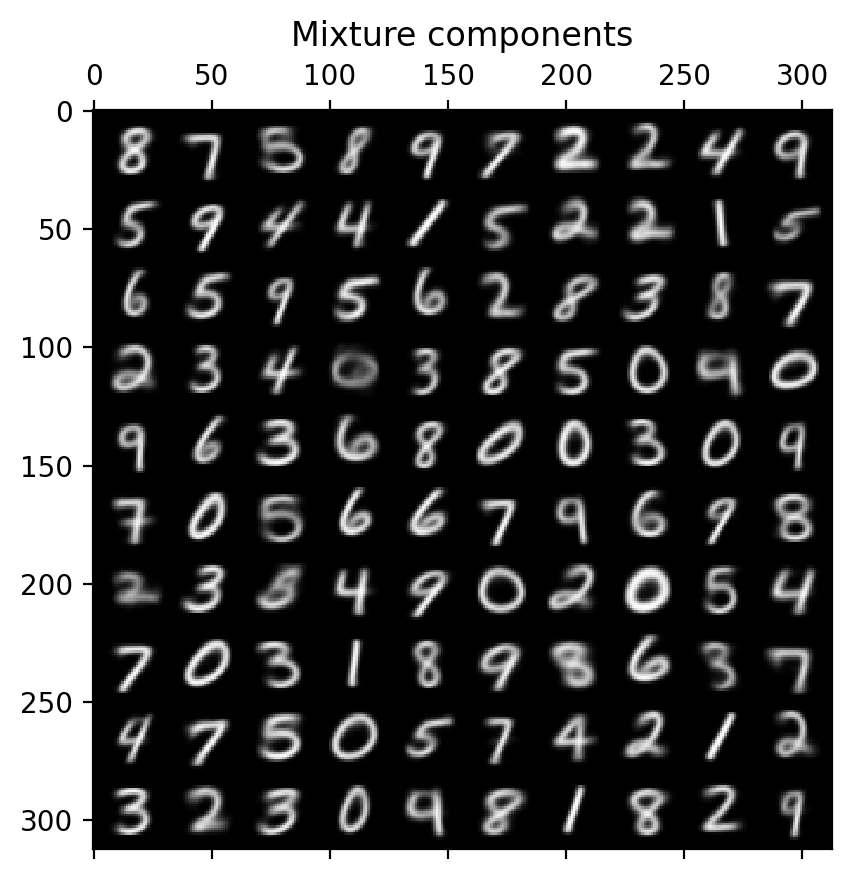

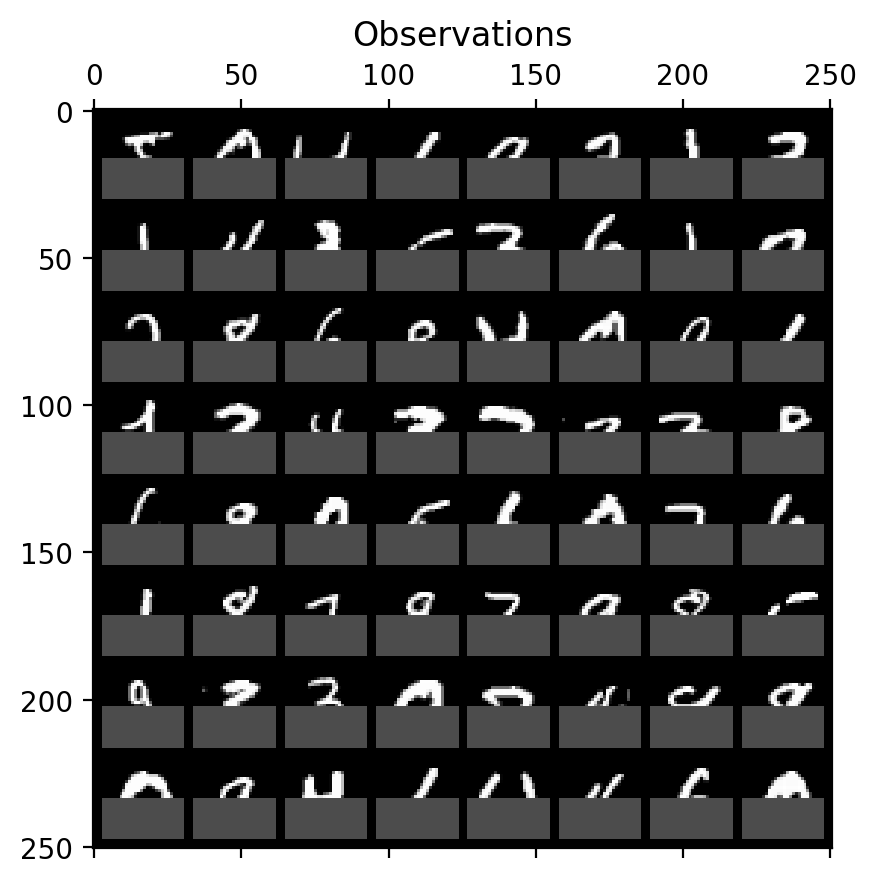

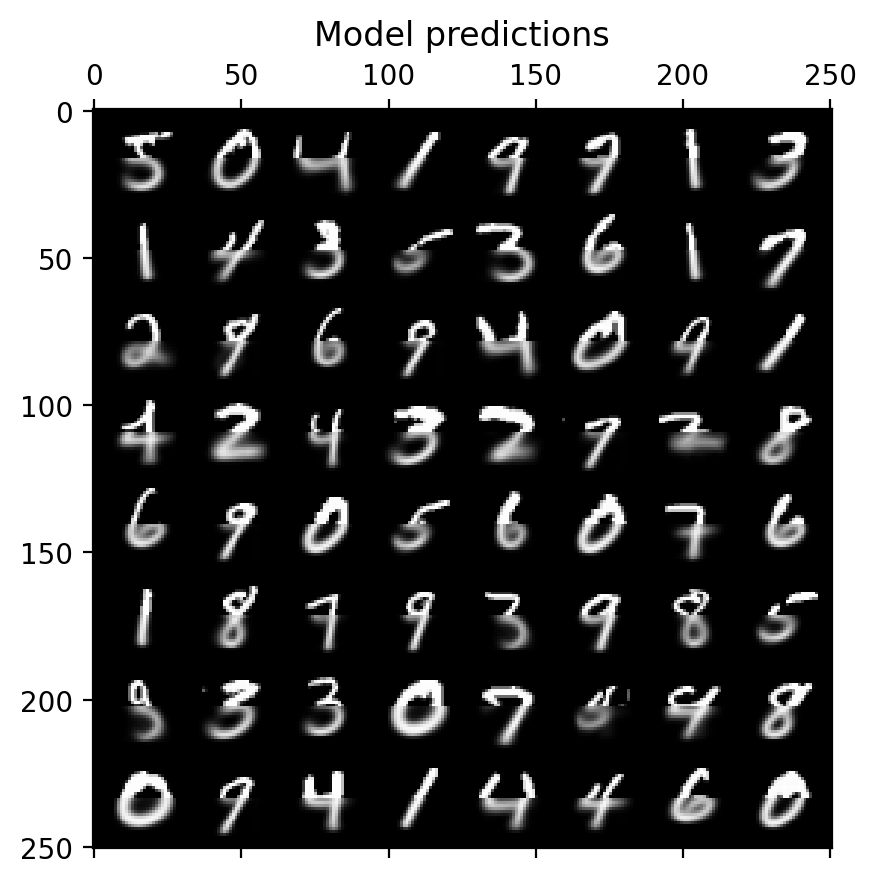

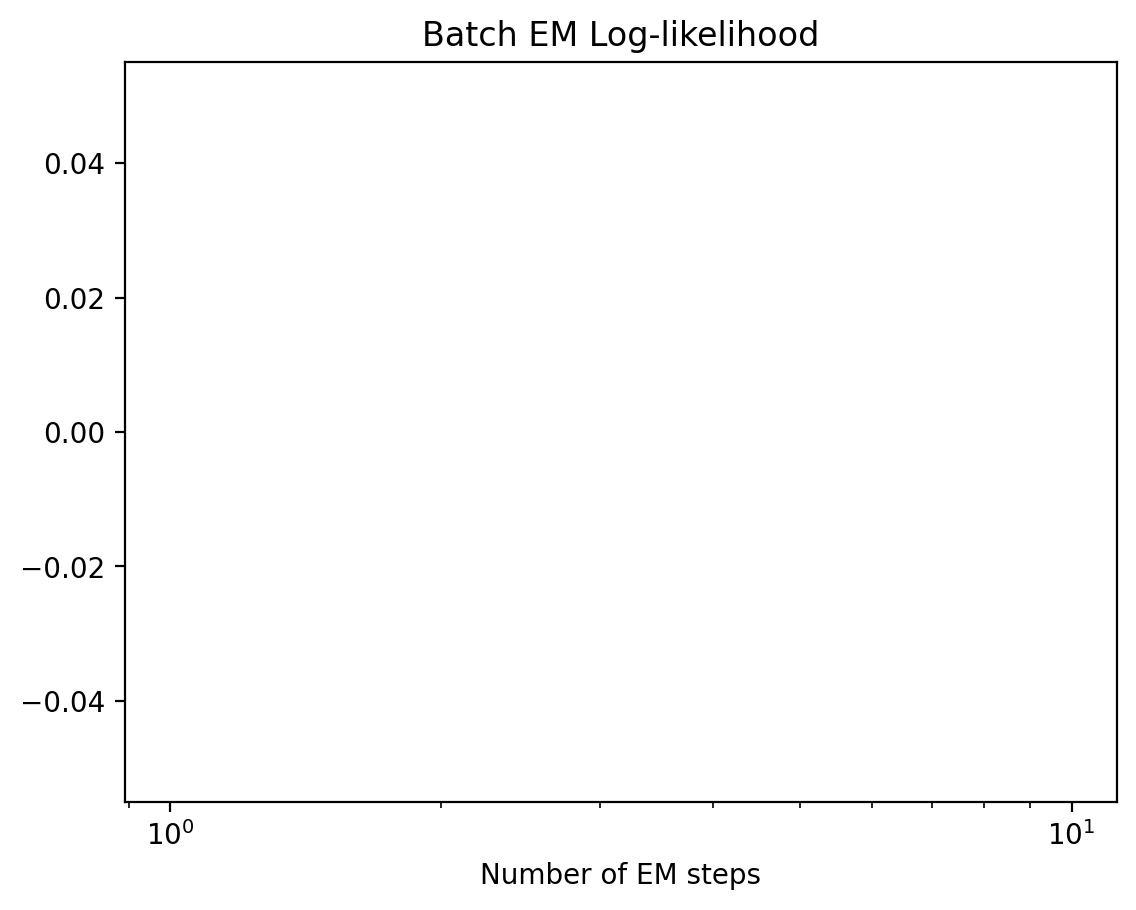

In [148]:
%%time

# This may take some time to finish.
model, loglik_vals, time = train_with_em(
    num_components=100, 
    num_steps=60,
)

### Task 4B.3: Speeding up EM with Online Updates (20pt)

So far, our Expectation-Maximization (EM) algorithm updates parameters by iterating over the entire dataset in each step. This is known as Batch EM. However, when dealing with large datasets, this approach can be slow and computationally expensive.

A more efficient alternative is Online EM, where:
- Instead of computing updates using all data points, we process mini-batches at a time.
- Model parameters are updated incrementally, allowing us to make progress without needing the full dataset.

This technique reduces computational cost and often speeds up convergence.

#### Key Idea: Stochastic Approximation
Instead of fully computing the standard EM updates:

$$
\mathbf{\pi}^{(t+1)} = \frac{\sum_{i=1}^{N} R^{(i)}}{N}
$$

we use an incremental update:

$$
\mathbf{\pi}^{(t+1)} = (1 - \eta_t) \mathbf{\pi}^{(t)} + \eta_t \cdot \frac{1}{B} \sum_{i \in \mathcal{B}} R^{(i)}
$$

where:
- $B$ is the mini-batch size (e.g., 1000 samples instead of the full dataset).
- $\eta_t$ is a learning rate that decreases over time to prevent instability:

$$
\eta_t = \frac{1}{t+1}
$$

This ensures that as the algorithm progresses, updates become smaller, allowing the parameters to stabilize.

The same update is applied to $\mathbf{\Theta}$ (pixel probabilities per cluster):

$$
\mathbf{\Theta}^{(t+1)} = (1 - \eta_t) \mathbf{\Theta}^{(t)} + \eta_t \cdot \frac{R^T X}{\sum R}
$$

#### Your Task: Implement Online EM
Complete the `train_with_online_em()` method for the online EM algorithm. Specifically, you will:
1. Use mini-batches instead of processing the entire dataset.
2. Implement a decaying learning rate \( \eta_t \).
3. Compare the convergence speed with Batch EM.


In [149]:
def train_with_online_em(num_components=100, num_steps=50, batch_size=1000, prior=None, draw_every=5):
    """
    Train the Mixture of Bernoullis model using online EM with masking.
    
    Args:
        num_components: Number of mixture components (clusters).
        num_steps: Total number of EM iterations.
        batch_size: Number of data points in each mini-batch.
        prior: Prior over parameters.
        draw_every: Frequency of visualization.
    
    Returns:
        model: Trained mixture model.
        loglik_vals: Log-likelihood at each iteration (for comparison).
        elapsed_time: Time taken for training.
    """
    import time

    if prior is None:
        prior = Prior.default_prior()

    # Load dataset
    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    X_test = util.read_mnist_images(TEST_IMAGES_FILE)
    num_data, num_pixels = X.shape

    # Create a mask that includes only the top half of pixels
    M = np.zeros(X.shape, dtype=int)
    M[:, :M.shape[1] // 2] = 1

    # Initialize model
    model = Model.random_initialization(prior, num_components, num_pixels)

    loglik_vals = []
    start_time = time.time()

    for t in range(1, num_steps + 1):
        # ##################################################################################
        ### YOUR CODE BELOW - just replace # comments with your code
        batch_indices = np.random.choice(num_data, batch_size, replace=False) 
        X_batch = X[batch_indices]
        M_batch = M[batch_indices]

        ### YOUR CODE BELOW: Compute responsibilities (E-step)
        R_batch = model.compute_posterior(X_batch, M_batch)

        # Adaptive learning rate
        eta_t = 1.56 / (t + 1)  # You may tune this later for better results

        ### YOUR CODE HERE: Update parameters incrementally (M-step)
        model.params.pi =(1- eta_t) * model.params.pi + eta_t * np.mean(R_batch) 
        model.params.theta = (1 - eta_t) * model.params.theta + eta_t * np.dot(R_batch.T, X_batch) / np.sum(R_batch)
        # ##################################################################################

        # Compute log-likelihood
        loglik = model.log_likelihood(X) / num_data
        loglik_vals.append(loglik)

        if (t + 1) % draw_every == 0:
            model.visualize_components()
            model.visualize_predictions(X[:64, :], M[:64, :])  # Use the mask for visualization

            pylab.figure('Log-likelihood')
            pylab.clf()
            pylab.semilogx(np.arange(1, len(loglik_vals) + 1), loglik_vals)
            pylab.title('Online EM Log-likelihood')
            pylab.xlabel('Number of Online EM steps')
            pylab.draw()

    elapsed_time = time.time() - start_time

    print('Final training log-likelihood:', model.log_likelihood(X) / num_data)
    print('Final test log-likelihood:', model.log_likelihood(X_test) / X_test.shape[0])
    print(f"Time elapsed: {elapsed_time:.2f} seconds")

    return model, loglik_vals, elapsed_time


Final training log-likelihood: -210.71931919785004
Final test log-likelihood: -210.54146775198268
Time elapsed: 16.34 seconds
CPU times: user 13.7 s, sys: 2.82 s, total: 16.5 s
Wall time: 16.7 s


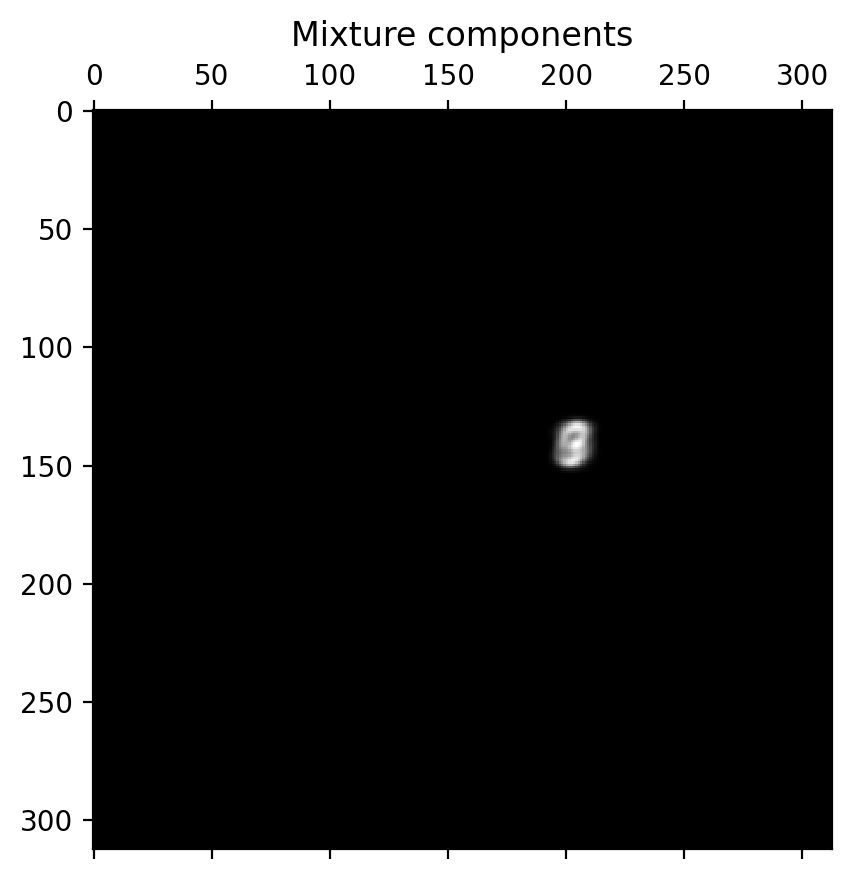

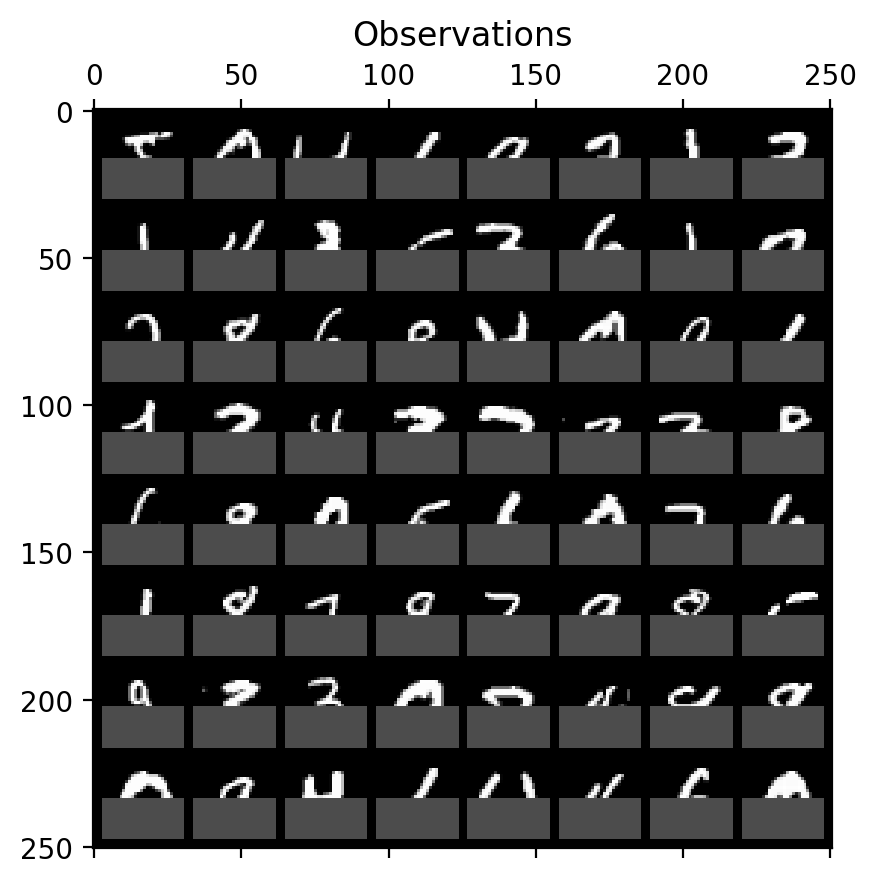

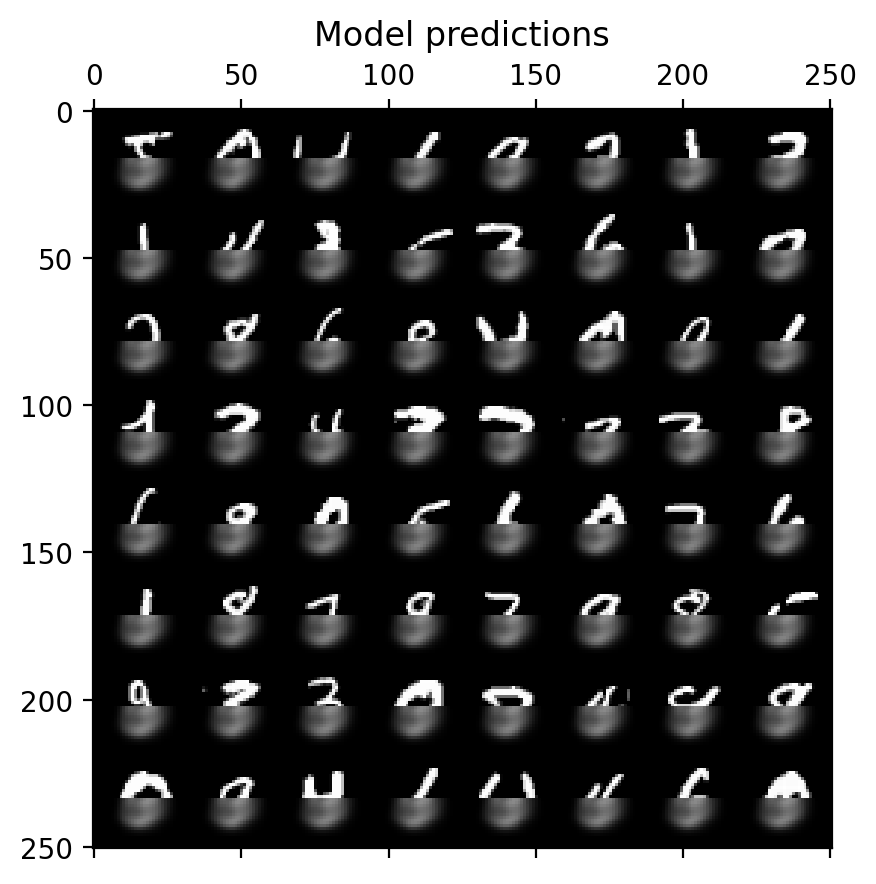

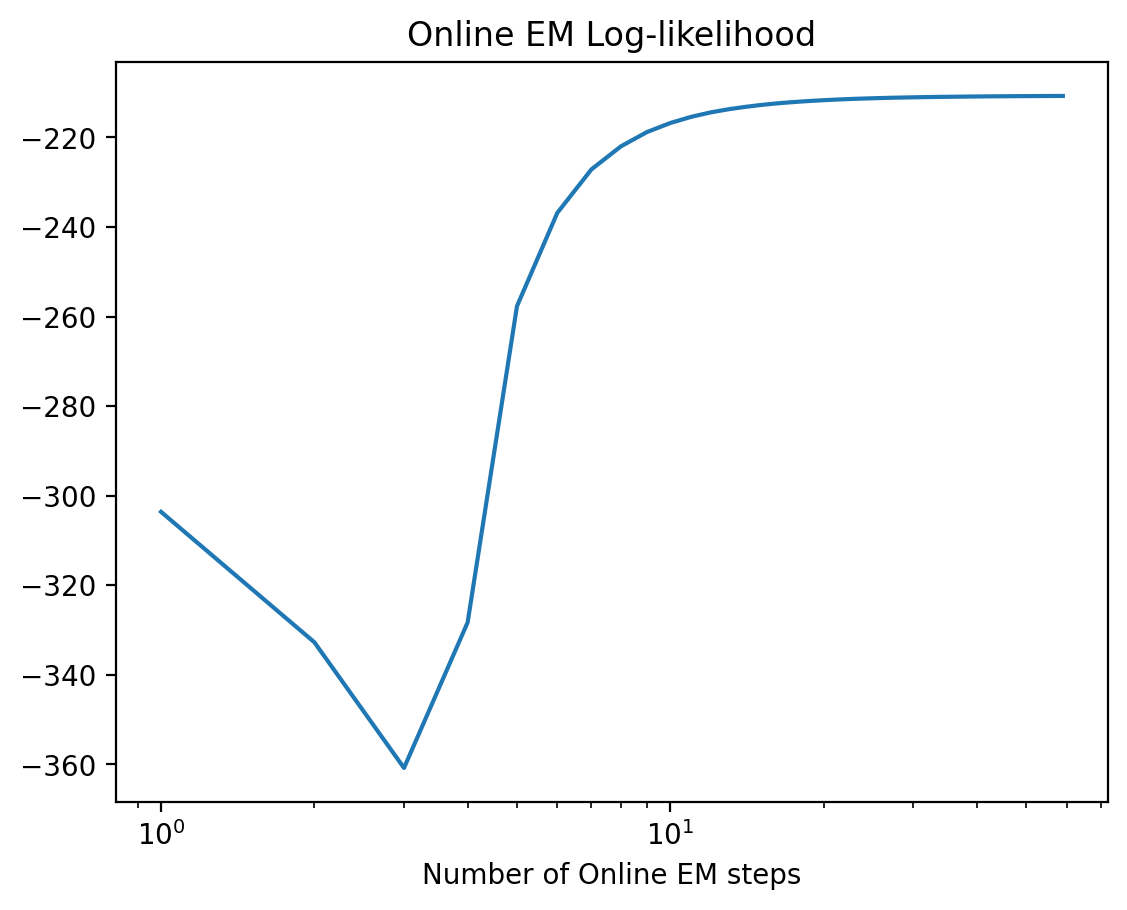

In [150]:
%%time

# Run Online EM
online_model, online_loglik, online_time = train_with_online_em(
    num_components=100, 
    num_steps=60, 
    batch_size=5000,
)

Plot the log-likelihood curves to compare the convergence of Batch EM vs. Online EM.

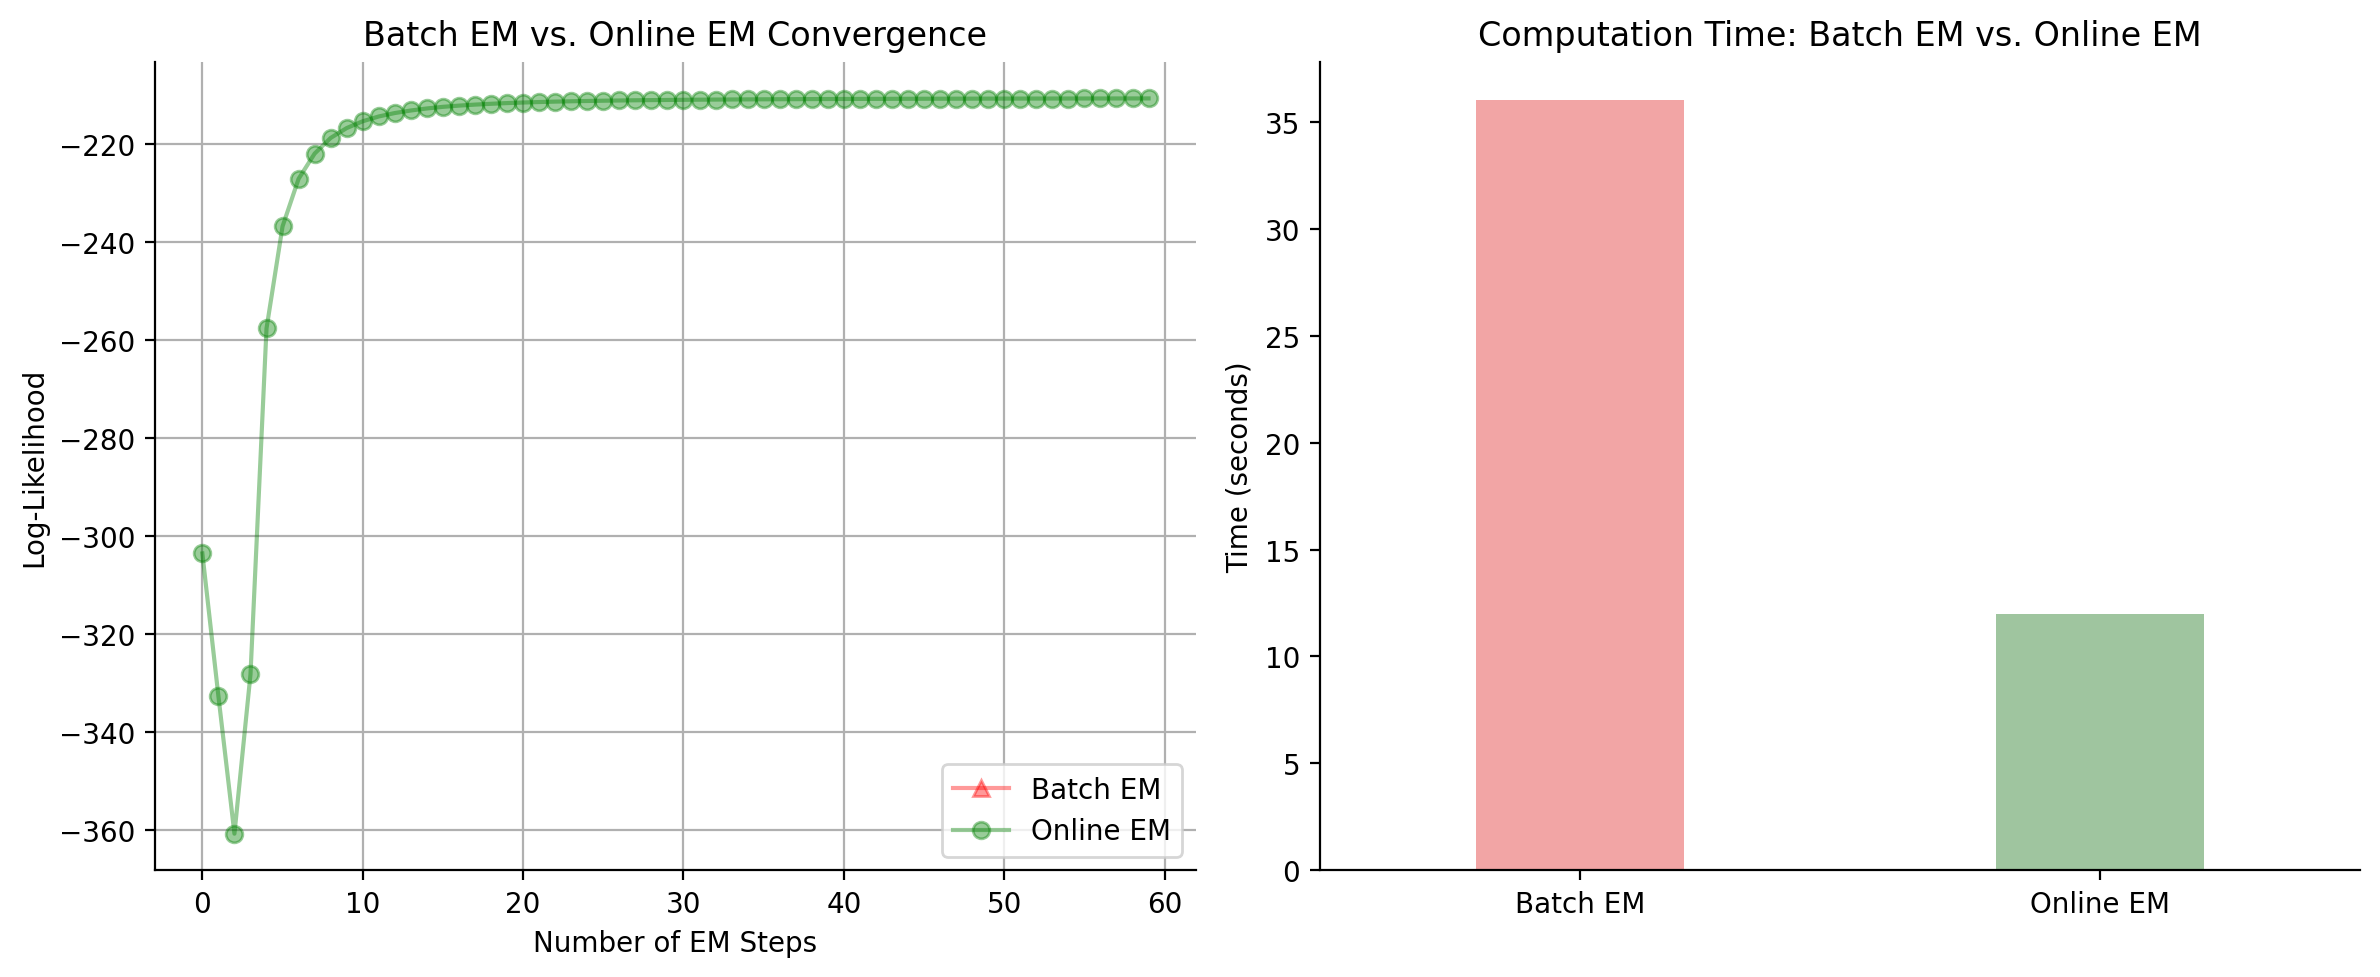

In [151]:
import matplotlib.pyplot as plt
import seaborn as sea  # Run `!pip install seaborn` if you do not have it already

# Data for bar plot
methods = ["Batch EM", "Online EM"]
times = [36, 12]  # Replace with actual values if available

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Log-Likelihood Convergence
axes[0].plot(loglik_vals, label="Batch EM", linestyle="-", marker="^", color='red', alpha=0.4)
axes[0].plot(online_loglik, label="Online EM", linestyle="-", marker="o", color='green', alpha=0.4)
axes[0].set_xlabel("Number of EM Steps")
axes[0].set_ylabel("Log-Likelihood")
axes[0].set_title("Batch EM vs. Online EM Convergence")
axes[0].legend()
axes[0].grid(True)
sea.despine()

# Plot Computation Time Comparison
sea.barplot(x=methods, y=times, hue=methods, palette=["red", "green"], alpha=0.4, ax=axes[1], width=0.4)
axes[1].set_ylabel("Time (seconds)")
axes[1].set_title("Computation Time: Batch EM vs. Online EM")
sea.despine()

# Show the plots
plt.tight_layout()
plt.show()

#### Questions: 

Compare the performance of Batch EM and Online EM based on your results.  
- Summarize your key observations about their convergence behavior and efficiency.  
- Online EM starts with a lower log-likelihood than Batch EM. Why might this happen?  
- Given that Batch EM took `time` seconds and Online EM took `online_time` seconds (as we calculated in the training code), which method would you prefer, and under what circumstances?

**YOUR ANSWER**



## Task 4C (Bonus): Comparing Gaussian Bayes Classifer, Fisher's LDA and Logistic Regression (20pts)

### Background

In this section, we're going to compare generative and discriminative methods on various binary datasets. First, a reminder on the theoretical background:

**1. Gaussian Bayes Classifier (GBC):**
GBC models the class label distribution as $(y = +1) \sim Bernoulli(p_+)$, and model features as multivariate Gaussians:
$$
(\mathbf{x} | y = +1) \sim \mathcal{N} (\mathbf{x}; \mu_+, \Sigma_+), \quad (\mathbf{x} | y = -1) \sim \mathcal{N} (\mathbf{x}; \mu_-, \Sigma_-) 
$$

The MLE for the parameters are in the notes, and will be repeated in the subsections below. Note that Gaussian Naive Bayes (as per Part A) is simply the case where the covariance matrices $\Sigma_+$ and $\Sigma_-$ are diagonal. 

**2. Fisher's LDA:** (Henceforth, just LDA) Same as GBC, with the additional assumptions that $p_+ = 1/2$ and $\Sigma_+ = \Sigma_- = \Sigma$.

**3. Logistic Regression:**
We seek to minimize the empirical logistic loss: 

$$
L = \frac{1}{n} \sum_{i = 1}^n \ln(1 + \exp(- y_i \mathbf{w}^\top \mathbf{x}_i))
$$


### Summary of tasks
At a high level, your task in this section is to implement the above 4 methods and see which method works better on which dataset, as well as the impact of having a bigger training set on these methods and datasets.

### Starter Code

Some basic libraries are imported here for you. Note the linear algebra tools we import from `scipy.linalg`.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, det, pinv, eigvalsh
import numpy.random as random
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
np.seterr(over='ignore', under='ignore')


{'divide': 'warn', 'over': 'ignore', 'under': 'ignore', 'invalid': 'warn'}

The class `Classifier` implements the `score` function.

In [ ]:
class Classifier:
    def predict(self,X):
        raise NotImplementedError
    def score(self,X,y):
        """Accuracy rate"""
        return np.mean(self.predict(X)==y)

The class `Gaussian2DMix` contains information of a binary Gaussian mixture. We will use this base class for both learning a dataset (assigning means, covariance matrices and priors to learned parameters) and generating a dataset (generate points with manually entered parameters).

Note that throughout, we use index 0 for the label -1, and index 1 for the label +1.

In [ ]:
LABELS = [-1, 1]
class Gaussian2DMix(Classifier):
    """Represents a mixture of Gaussians, with one label per Gaussian."""
    def __init__(self,mus=[np.array([-1,0]),np.array([1,0])],Sigmas=[np.eye(2), np.eye(2)],ps=None,labels=LABELS):
            """Instantiate the mixture based on specified parameters
            self.mus is an array of length 2 of the means.
            self.Sigmas is an array of length 2 of the covariance matrices.
            self.ps are is an array of length 2 over the the priors. Note that the elements should add up to 1.
            """
            if ps is None: # default to uniform over the components
                ps = np.array([1/len(labels)]*len(labels))
            self.mus=mus
            self.Sigmas=Sigmas
            self.ps=ps
            self.labels=labels
    def generate(self,m):
        """Generate m samples from the mixture
        Returns (X, y) where
            X.shape = (m, 2)
            y.shape = (m,)
        """
        # Pick m class labels from priors
        y = random.choice(self.labels, p=self.ps, size=m)
        x = np.empty((m, 2))
        for label, mu, Sigma in zip(self.labels, self.mus, self.Sigmas):
            thism = sum(y == label)
            # Generate x from p(x | y)
            x[y == label] = random.randn(thism, 2) @ sqrtm(Sigma) + mu
        return x,y
    
    def discriminant(self, X):
        raise NotImplementedError
    
    def predict(self, X):
        return np.sign(self.discriminant(X))

A scatter plot helper function is provided for you. Note that -1 labels are assigned the color red, +1 labels are assigned the color blue.

In [ ]:
def scatter_plot(X, y, cmap_fg = {-1:'#FF0000', 1:'#0000FF'}, **plot_kwargs):
    labels = np.unique(y)
    plt.figure(figsize=(8, 6))
    for l in labels:
        l_idxs = np.where(y == l)
        plt.scatter(X[l_idxs, 0], X[l_idxs, 1], label=l, c=cmap_fg[l], **plot_kwargs)
    plt.legend()

### The datasets

We're going to investigate 4 binary datasets generated from various 2D Gaussian mixtures. You should not modify any of the prescribed parameters below. For each dataset, 200 samples are visualized below.

#### Source 1. "Standard"

Source 1 data is generated from
$$
\mu_- = \begin{pmatrix}
-1 \\
0
\end{pmatrix}, \mu_+ = \begin{pmatrix}
1 \\
0
\end{pmatrix}, \Sigma_- = \Sigma_+ = \begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}, p_+ = \frac{1}{2}
$$

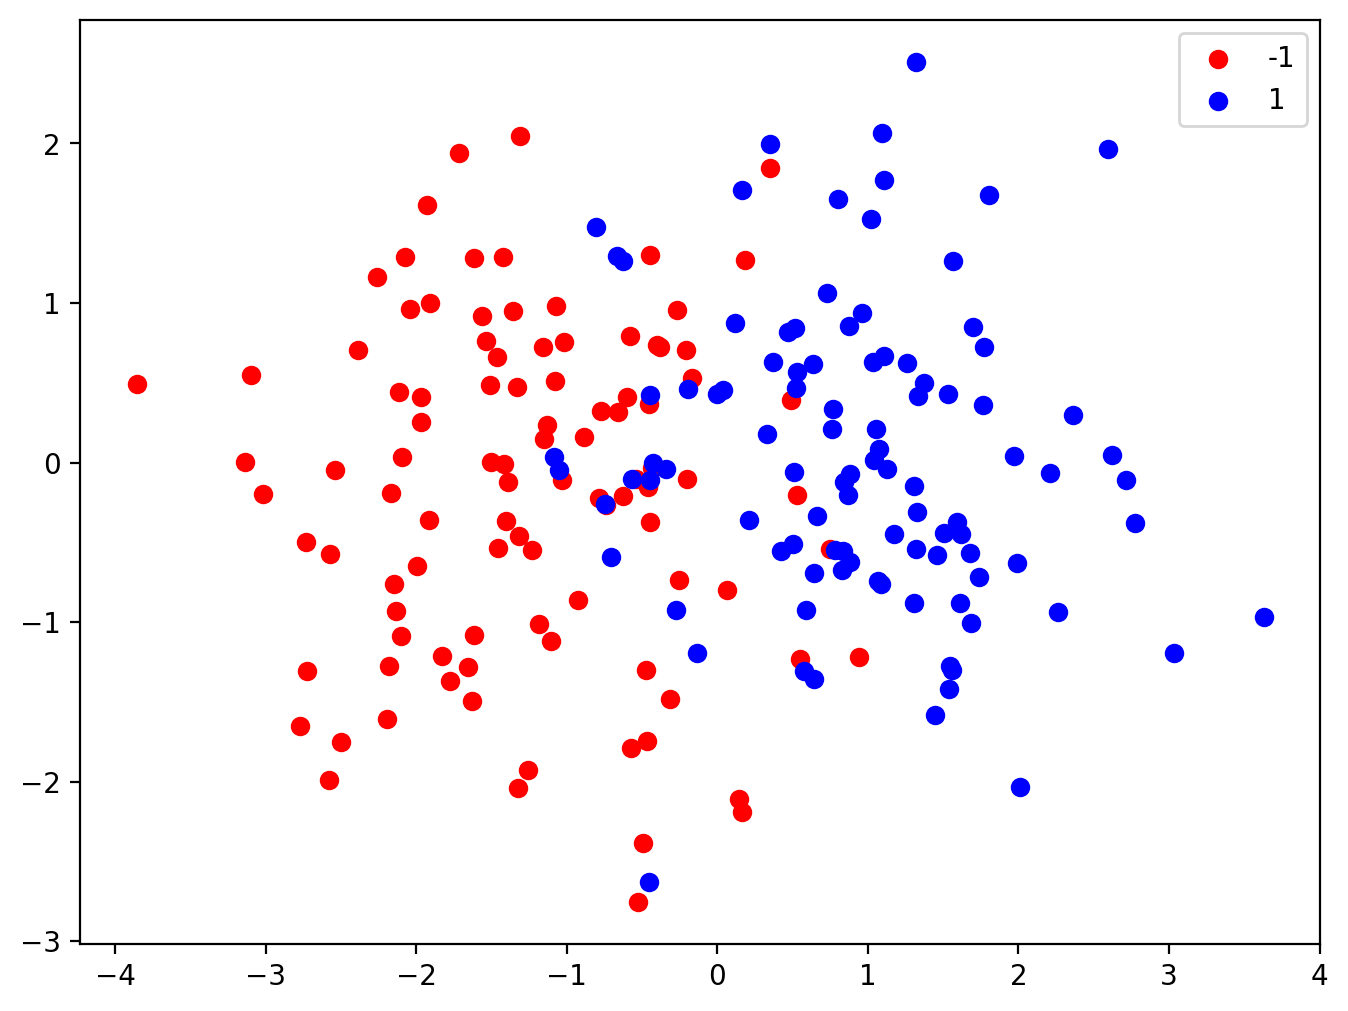

In [ ]:
source_1 = Gaussian2DMix(mus = np.array([[-1, 0],
                                       [1, 0]])).generate

scatter_plot(*source_1(200))

#### Source 2. "Skewed"

Source 2 data is generated from
$$
\mu_- = \begin{pmatrix}
-1 \\
0
\end{pmatrix}, \mu_+ = \begin{pmatrix}
2 \\
0
\end{pmatrix}, \Sigma_- = \begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}, \Sigma_+ = \begin{pmatrix}
3 & 2.5 \\
2.5 & 3
\end{pmatrix},  p_+ = \frac{1}{2}
$$

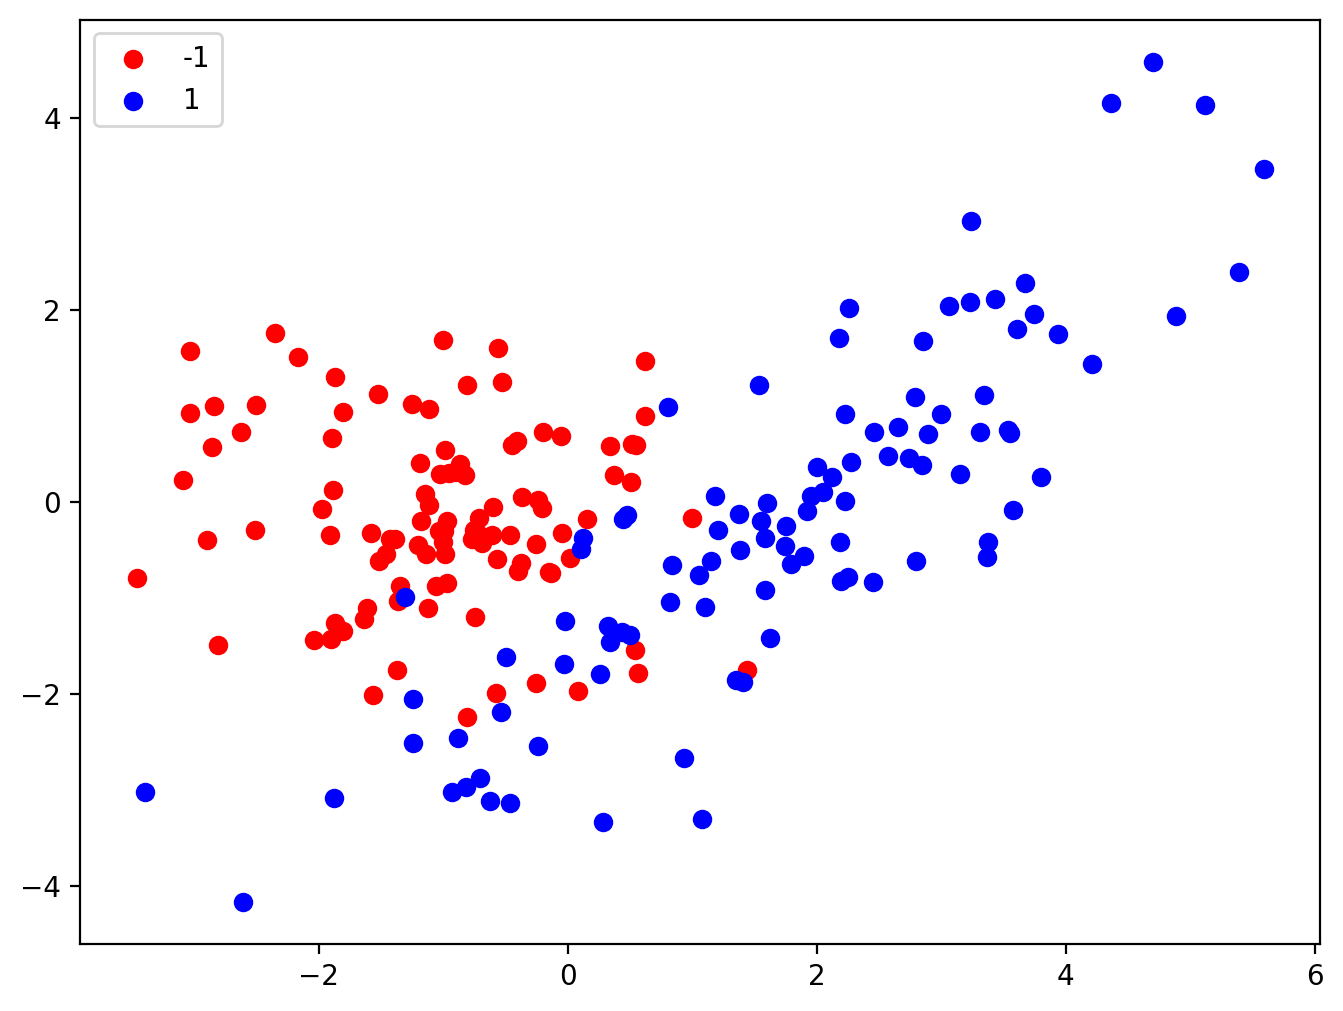

In [ ]:
source_2 = Gaussian2DMix(mus = np.array([[-1, 0],
                                         [2, 0]]), 
                         Sigmas=[np.eye(2),np.array([[3, 2.5],
                                           [2.5, 3]])]).generate

scatter_plot(*source_2(200))

#### Source 3: "Horizontal/Vertical"

Source 3 data is generated from
$$
\mu_- = \begin{pmatrix}
0 \\
0
\end{pmatrix}, \mu_+ = \begin{pmatrix}
10 \\
0
\end{pmatrix}, \Sigma_- = \begin{pmatrix}
0.49 & 0 \\
0 & 100
\end{pmatrix}, \Sigma_+ = \begin{pmatrix}
36 & 0 \\
0 & 0.04
\end{pmatrix},  p_+ = \frac{1}{2}
$$

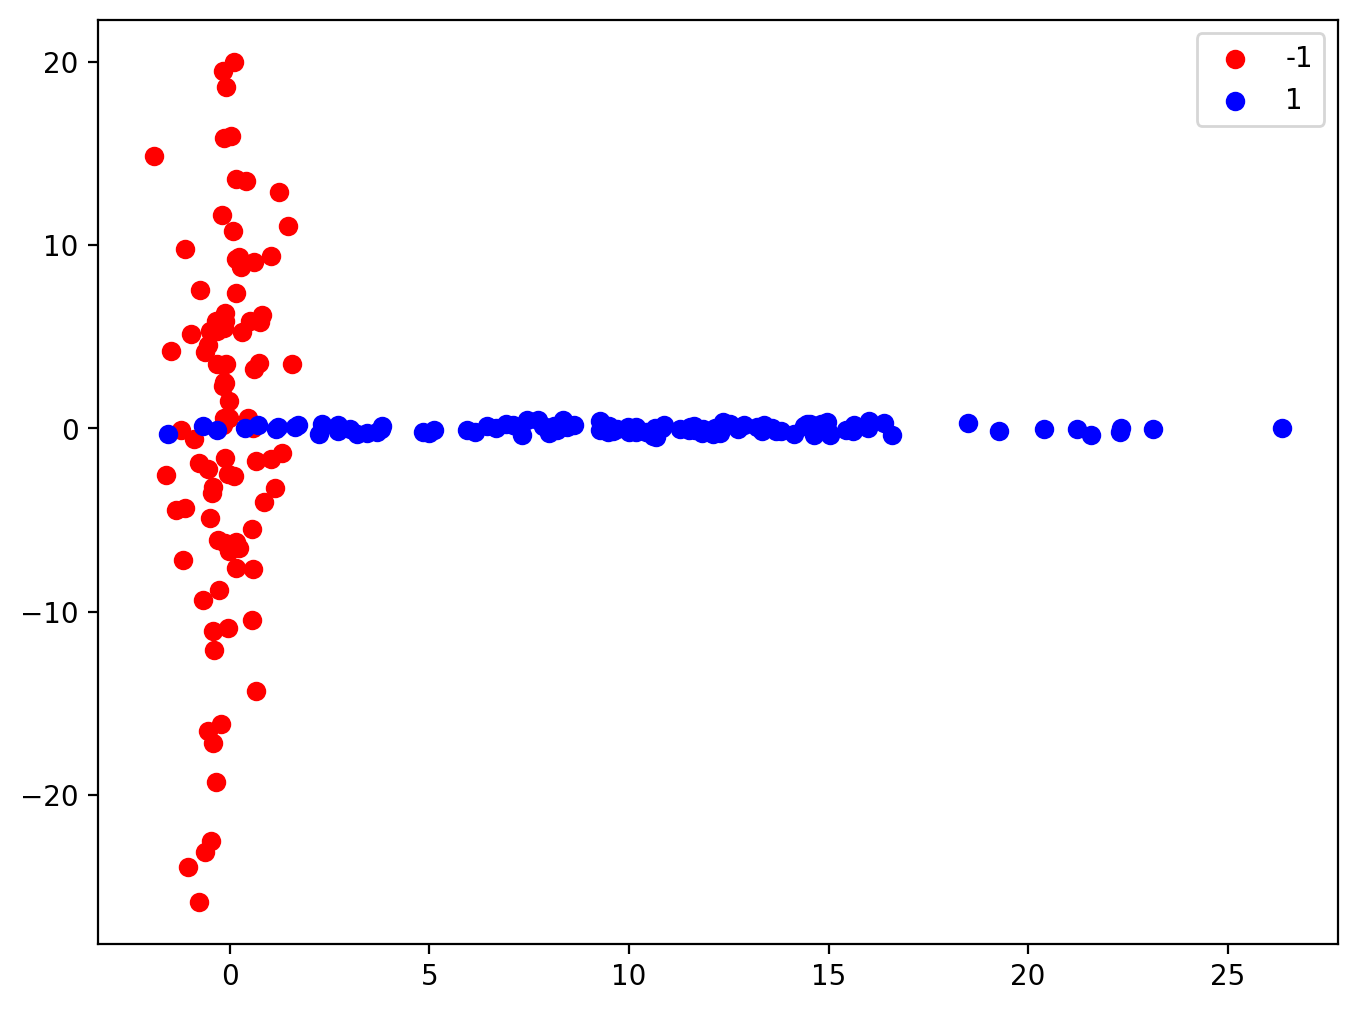

In [ ]:
source_3 = Gaussian2DMix(mus = np.array([[0, 0],[10, 0]]),
                         Sigmas = [ np.diag([0.7, 10]) ** 2,
                                   np.diag([6, 0.2]) **2]).generate

scatter_plot(*source_3(200))

#### Source 4: "Class Imbalance"

Source 4 data is generated from
$$
\mu_- = \begin{pmatrix}
-1 \\
0
\end{pmatrix}, \mu_+ = \begin{pmatrix}
1 \\
0
\end{pmatrix}, \Sigma_- = \Sigma_+ = \begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}, p_+ = 0.2
$$

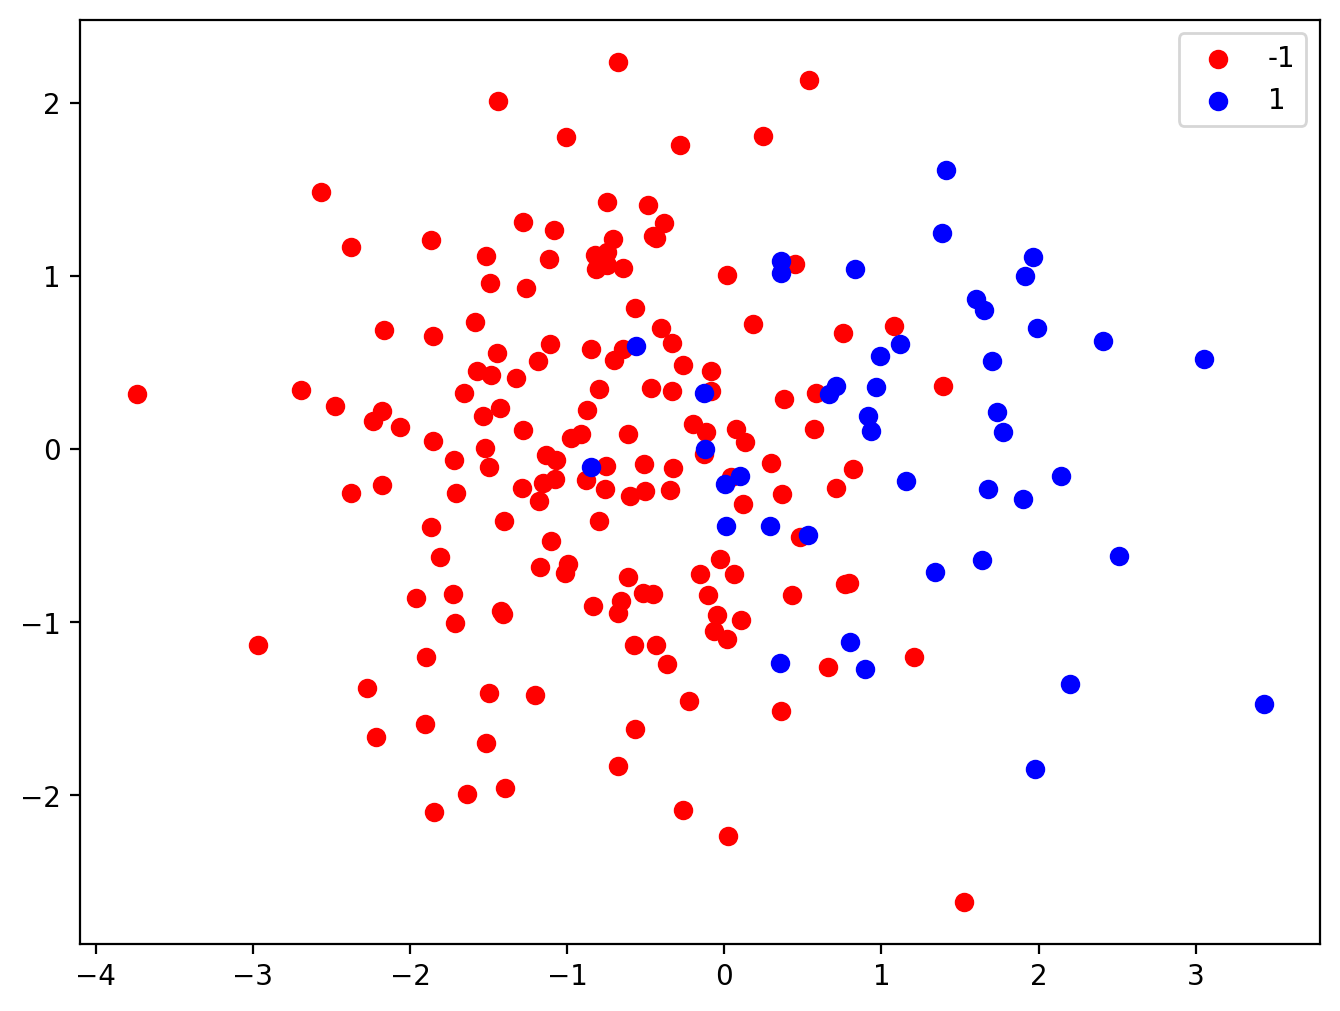

In [ ]:
source_4 = Gaussian2DMix(mus = np.array([[-1, 0],
                                         [1, 0]]), ps=[0.8, 0.2]).generate

scatter_plot(*source_4(200))

A plotting utility function is provided. Note that it plots training data, and takes in a trained classifier `clf` that implements the ``predict`` method, and plots the test data along with the classifier's prediction.

In [ ]:
def plot_decision_boundary(clf, X_train, y_train, X_test, y_test,  ax=None,
                           cmap_bg = ListedColormap(['#FFAAAA', '#AAAAFF']), cmap_fg = {-1:'#FF0000', 1:'#0000FF'}):
    """
        Plots the decision boundary of the given classifier on training and testing points.
        Colors the training points with true labels, and shows the incorrectly and correctly predicted test points.
    """
    if ax is None:
        fig, ax = plt.figure(figsize=(8, 6))
    X, y = np.vstack([X_train, X_test]), np.hstack([y_train.flatten(), y_test.flatten()])
    labels = np.unique(y)
    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
    
    # Create a mesh of points
    x1s = np.linspace(x_min[0], x_max[0], 100)
    x2s = np.linspace(x_min[1], x_max[1], 100)
    xx1, xx2 = np.meshgrid(x1s, x2s)
    Z = clf.predict(np.c_[xx1.ravel(), xx2.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx1.shape)
    ax.pcolormesh(xx1, xx2, Z, cmap=cmap_bg, shading='auto')

    # Plot training points
    for l in labels:
        l_idxs = np.where(y_train == l)
        ax.scatter(X_train[l_idxs, 0], X_train[l_idxs, 1], label=f'train/{l}', c=cmap_fg[l], marker='.')
    
    # Plot test points
    y_test_predict = clf.predict(X_test)
    for l in labels:
        # Mark the wrong ones
        wrong_idxs = np.where((y_test == l) & (y_test_predict != y_test))
        ax.scatter(X_test[wrong_idxs, 0], X_test[wrong_idxs, 1], label=f'test/should be {l} (wrong)', c=cmap_fg[l], marker='x', s=100)

        # Plot the correct ones
        corr_idxs = np.where((y_test_predict == l) & (y_test_predict == y_test))
        ax.scatter(X_test[corr_idxs, 0], X_test[corr_idxs, 1], label=f'test/predicted {l} (correct)', c=cmap_fg[l], marker='+', s=50)
        
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Decision boundary\nShaded regions show what the label clf would predict for a point there')
    plt.legend(title='label', bbox_to_anchor=(1.04, 1), loc='upper left')


### Task 4C.1: GBC and LDA (5pts)

#### Your Task:
Implement the GBC and LDA classifiers **through the use of a discriminant function $r(\mathbf{x})$**.

Recall that 
$$
P(y = +1 | \mathbf{x}) = \frac{1}{1 + e^{-r(\mathbf{x})}}
$$
and the prediction is simply $\hat{y} = sign(r(\mathbf{x}))$.

For GBC, an analysis similar to the one done in class yields

$$
r(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top (\Sigma_-^{-1} - \Sigma_+^{-1}) \mathbf{x} + \mathbf{x}^\top (\Sigma_+^{-1} \mu_+ - \Sigma_-^{-1} \mu_-) + (\ln \frac{p_+}{1 - p_+} - \frac{1}{2} \mu_+^\top \Sigma_+^{-1} \mu_+ + \frac{1}{2} \mu_-^\top \Sigma_-^{-1} \mu_- - \frac{1}{2} \ln \det (\Sigma_+) + \frac{1}{2} \ln \det (\Sigma_-))
$$

We emphasize that this is linear in the quadratic feature space.

For LDA, 

$$
r(\mathbf{x}) = \mathbf{x}^\top (\Sigma_- (\mu_+ - \mu_-)) + (\ln \frac{p_+}{1 - p_+} - \frac{1}{2} \mu_+^\top \Sigma^{-1} \mu_+ + \frac{1}{2} \mu_-^\top \Sigma^{-1} \mu_-)
$$

where we note that this is just the simplification of the above when $\Sigma_+ = \Sigma_- = \Sigma$, and $p_+ = 1 - p_+ = 0.5$. We emphasize that this is simply linear in $\mathbf{x}$.

In the implementations below, you are highly encouraged to use matrix operations for efficiency. You should first implement `fit`, which will set the parameters of the 2D Gaussian Mixture to their MLE; and then implement `discriminant` using these learned parameters. Though it is possible, you should not implement this in the probabilistic sense as per Part A -- the point of this task is to flesh out the nature of the underlying discriminant.

**Report:** Include in your report code snippets of your GBC and LDA discriminant functions. You do not need to include formulas for $r(\mathbf{x})$.

In [ ]:
def plogdeth(A):
    """Stably returns the log of the determinant of a symmetric matrix A."""
    v = eigvalsh(A)
    return np.sum(np.log(v[~np.isclose(v,0)]))


class GBC(Gaussian2DMix):
    def fit(self, Xs, ys):
        #### YOUR CODE BELOW
        self.ps = None
        self.mus = None
        self.Sigmas = None
        #### YOUR CODE ABOVE

    def discriminant(self, X):
        mu_neg, mu_pos = self.mus[0], self.mus[1]
        Sigma_neg, Sigma_pos = self.Sigmas[0], self.Sigmas[1]
        p_neg, p_pos = self.ps[0], self.ps[1]

        Sigma_neg_inv = pinv(Sigma_neg)
        Sigma_pos_inv = pinv(Sigma_pos)
        log_det_neg = plogdeth(Sigma_neg)
        log_det_pos = plogdeth(Sigma_pos)

        #### YOUR CODE BELOW
        r_x = None
        #### YOUR CODE ABOVE
        return r_x

class LDA(Gaussian2DMix):
    def fit(self, Xs, ys):
        #### YOUR CODE BELOW
        self.ps = None
        self.mus = None
        self.Sigmas = None
        #### YOUR CODE ABOVE

    def discriminant(self, X):
        #### YOUR CODE BELOW
        w = None
        b = None
        #### YOUR CODE ABOVE
        return X @ w + b

### Task 4C.2: LogisticRegression (5pts)

#### Your Task:

Implement the `LogisticRegression` classifier below. Note the structure of the class, and that we're using `scipy` to perform the optimization for us.

**Report**: In your report, include code snippets of your implementation of `LogisticReg`.

In [ ]:
from scipy.optimize import minimize
class ERMLinearClassifier(Classifier):
    def fit(self, Xs, ys):
        # Append a column of 1s to the feature matrix
        Xs = np.hstack([Xs, np.ones((Xs.shape[0], 1))])
        yX = ys[:, np.newaxis] * Xs
        m, d = yX.shape

        def training_obj(w):
            return self.loss_func(yX, w)
        
        def training_grad(w):
            """Returns the derivative of the loss wrt w"""
            return self.loss_derivative(yX, w)
        
        minimization = minimize(training_obj, np.zeros(d), jac=training_grad)
        self.w = minimization.x
        self.b = self.w[-1]
        self.w = self.w[:-1]
    
    def predict(self, X):
        return np.sign(X @ self.w + self.b)
        

class LogisticReg(ERMLinearClassifier):
    def loss_func(self, yX, w):
        #### YOUR CODE BELOW
        return
        #### YOUR CODE ABOVE

    def loss_derivative(self, yX, w):
        #### YOUR CODE BELOW
        return
        #### YOUR CODE ABOVE

### Task 4C.3: Analysis (5pts)

Finally we're ready for some analysis. The code below is provided for you to compare the decision boundaries that each model draws for each dataset.

**Report:** Include the generated plot, and discuss/answer the following questions:

1. For each dataset, give qualitative remarks about the decision boundary that each model draws.
2. Relate your observations in 1. to the linear separability (or lack thereof) of each dataset, as well as the structure of the discriminant/prediction functions.
3. Relate your observations in 1. to the assumptions made by GBC and LDA respectively. On which dataset did their (qualitative) performance/boundary differ?

In [ ]:
methods = { 'GBC': GBC(), 'LDA': LDA(), 'logistic': LogisticReg() }

sources = {'Standard': source_1, 'Skewed': source_2, 'Horizontal/Vertical': source_3, 'Class Imbalance': source_4}

fig, axes = plt.subplots(len(sources), len(methods), figsize=(16, 12))

for row_idx, (source_name, source_func) in enumerate(sources.items()):
    X, y = source_func(400)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    for col_idx, (method_name, method) in enumerate(methods.items()):
        ax = axes[row_idx, col_idx]
        method.fit(X_train, y_train)
        plot_decision_boundary(method, X_train, y_train, X_test, y_test, ax)
        ax.set_title(f"{source_name} - {method_name}")

plt.tight_layout()
plt.show()

### Task 4C.4: Accuracy against size of training set (5pts)

Some code is provided for you to test the performance of each model as the size of the training data increases. You do not need to modify the code.

**Report:** In your report, include the generated plot and answer the following questions:
1. Roughly explain the structure of what the code is doing. In particular, point out what stochasticity/variance the `n_reps` is trying to alleviate, and where it comes from.
2. Qualitatively discuss the performance between the models. For each dataset, explain the discrepancy/similarity between their performances.
3. Discuss the performance of each model as size of training data increases.

In [ ]:
import matplotlib.pyplot as plt

training_sizes = np.linspace(20, 600, 5).astype(int)
n_reps = 10
accuracies = {source_name: {method_name: np.zeros(len(training_sizes)) for method_name in methods.keys()} for source_name in sources.keys()}

# Loop over each dataset
for source_name, source_func in sources.items():
    for _ in range(n_reps):
        X_test, y_test = source_func(1000)
        for ts_idx, m in enumerate(training_sizes):
            X_train, y_train = source_func(m)
            while len(np.unique(y_train))<2:
                X_train, y_train = source_func(m)
            # Loop over each method
            for method_name, method in methods.items():
                method.fit(X_train, y_train)
                accuracy = method.score(X_test, y_test)
                accuracies[source_name][method_name][ts_idx] += accuracy / n_reps

# Plot the accuracies
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

for idx, (source_name, source_accuracies) in enumerate(accuracies.items()):
    ax = axes[int(idx/2)][idx%2]
    for method_name, method_accuracies in source_accuracies.items():
        ax.plot(training_sizes, method_accuracies, label=method_name)
    ax.set_title(f'Accuracy vs Training Size for {source_name}')
    ax.set_xlabel('Training Size')
    ax.set_ylabel('Accuracy')
    ax.legend()

plt.tight_layout()
plt.show()